In [69]:
import requests
import pandas as pd
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
import seaborn as sns



#from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from statsmodels.tsa.arima_model import ARIMA
pd.set_option('display.max_rows', 3000)


# Loading Dataset

In [4]:
confirmed= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths= pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoverd=pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')

In [5]:
confirmed.head()
deaths.head()
recoverd.head()

Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  6/5/20  6/6/20  6/7/20  6/8/20  6/9/20  \
0        0        0        0  ...    1762    1830    1875    2171    2651   
1        0        0        0  ...     910     925     938     945     960   
2        0        0        0  ...    6453    6631    6717    6799    6951   
3        0        0        0  ...     741     741     744     751     757   
4        0        0        0  ...      21      24      24      38      38   

   6/10/20  6/11/20  6/12/20  6/13/20  6/14/20  
0     3013     3326     3928     4201     4725  
1      980     1001     1034     1039     1044  
2     7074     7255     7322     7420     7606  
3      759      780      781      781      781  
4       40       41       42       61       61  

[5 rows x 149 columns]

We have data regarding number of confirmed cases, deaths and recovered cases from Jan 22 till May31 

In [6]:
confirmed.shape
deaths.shape
recoverd.shape

(253, 149)

# Data Preprocessing

Unpivoting the data using dates as variables and then merging confirmed, deaths and recovered tables 
Number of countries in recoverd table are less than those in confirmed and deaths table. Assuming that the missing countries have zero recovery cases and hence replacing null values with"0". 

In [8]:
confirmed_df = confirmed.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Confirmed')

deaths_df = deaths.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Deaths')
recovered_df =recoverd.melt(id_vars=['Province/State', 'Country/Region', 'Lat', 'Long'], 
                            value_vars=confirmed.columns[4:], var_name='Date', value_name='Recovered')

In [9]:
recovered_df.head()

Province/State Country/Region      Lat     Long     Date  Recovered
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0
1            NaN        Albania  41.1533  20.1683  1/22/20          0
2            NaN        Algeria  28.0339   1.6596  1/22/20          0
3            NaN        Andorra  42.5063   1.5218  1/22/20          0
4            NaN         Angola -11.2027  17.8739  1/22/20          0

In [10]:
World_Data = pd.merge (confirmed_df,deaths_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )
World_Data = pd.merge (World_Data,recovered_df,how='left', on= ['Province/State', 'Country/Region', 'Date', 'Lat', 'Long'] )

In [11]:
print(World_Data.shape)
World_Data.head()

(38570, 8)


Province/State Country/Region      Lat     Long     Date  Confirmed  Deaths  \
0            NaN    Afghanistan  33.0000  65.0000  1/22/20          0       0   
1            NaN        Albania  41.1533  20.1683  1/22/20          0       0   
2            NaN        Algeria  28.0339   1.6596  1/22/20          0       0   
3            NaN        Andorra  42.5063   1.5218  1/22/20          0       0   
4            NaN         Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [12]:
World_Data.isna().sum()

Province/State    26825
Country/Region        0
Lat                   0
Long                  0
Date                  0
Confirmed             0
Deaths                0
Recovered          2465
dtype: int64

In [13]:
World_Data[World_Data['Recovered'].isna()]['Country/Region'].value_counts()

Canada         2030
Syria           145
Mozambique      145
Timor-Leste     145
Name: Country/Region, dtype: int64

High number of missing values for Canada's recovery data are observed. 

In [14]:
Null_df = World_Data[World_Data['Recovered'].isna()].groupby(['Date','Country/Region'])

In [15]:
World_Data=World_Data.fillna(0)

#World_Data=World_Data.drop(columns=['Province/State'])
World_Data.rename(columns={'Country/Region':'Country'},inplace=True)

In [16]:
World_Data.isna().sum()

Province/State    0
Country           0
Lat               0
Long              0
Date              0
Confirmed         0
Deaths            0
Recovered         0
dtype: int64

In [17]:
print(World_Data.shape)
World_Data.head()


(38570, 8)


Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0        0.0  
1        0.0  
2        0.0  
3        0.0  
4        0.0

In [18]:
World_Data['Recovered'] = World_Data['Recovered'].astype('int')
World_Data['Deaths'] = World_Data['Deaths'].astype('int')

In [19]:
World_Data.head()

Province/State      Country      Lat     Long     Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000  1/22/20          0       0   
1              0      Albania  41.1533  20.1683  1/22/20          0       0   
2              0      Algeria  28.0339   1.6596  1/22/20          0       0   
3              0      Andorra  42.5063   1.5218  1/22/20          0       0   
4              0       Angola -11.2027  17.8739  1/22/20          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [20]:
World_Data[World_Data['Country']=='India'].tail()

Province/State Country   Lat  Long     Date  Confirmed  Deaths  \
37371              0   India  21.0  78.0  6/10/20     286605    8102   
37637              0   India  21.0  78.0  6/11/20     297535    8498   
37903              0   India  21.0  78.0  6/12/20     308993    8884   
38169              0   India  21.0  78.0  6/13/20     320922    9195   
38435              0   India  21.0  78.0  6/14/20     332424    9520   

       Recovered  
37371     135206  
37637     147195  
37903     154330  
38169     162379  
38435     169798

In [21]:
World_Data.to_csv('Covid_World_Data.csv',index= False)

In [22]:
World_Data['Date']=pd.to_datetime(World_Data['Date'])
World_Data.head()

Province/State      Country      Lat     Long       Date  Confirmed  Deaths  \
0              0  Afghanistan  33.0000  65.0000 2020-01-22          0       0   
1              0      Albania  41.1533  20.1683 2020-01-22          0       0   
2              0      Algeria  28.0339   1.6596 2020-01-22          0       0   
3              0      Andorra  42.5063   1.5218 2020-01-22          0       0   
4              0       Angola -11.2027  17.8739 2020-01-22          0       0   

   Recovered  
0          0  
1          0  
2          0  
3          0  
4          0

In [23]:
World_Data.loc[World_Data['Country']=='Congo (Brazzaville)','Country']='DR Congo'

World_Data.loc[World_Data['Country']=='Congo (Kinshasa)','Country']='DR Congo'
World_Data.loc[World_Data['Country']=='Taiwan*','Country']='Taiwan'

Multiple entries for countries are merged to get cumulative data 


In [24]:
#!pip install folium
#!pip install plotly_express
#import folium
#import plotly as px
#Getting Recent information 
#df_w= World_Data[World_Data['Date']==max(World_Data['Date'])]
#gmap = folium.Map(zoom_start=1.5)
#for i in range(0, len(df_w)):
    #folium.Circle(
        #location=[df_w.iloc[i]['Lat'], df_w.iloc[i]['Long']],
        #color='black', fill='red',
        #tooltip =   '<li><bold>Country : '+str(df_w.iloc[i]['Country'])+'<li><bold>Province : '+str(df_w.iloc[i]['Province/State'])+'<li><bold>Confirmed : '+str(df_w.iloc[i]['Confirmed'])+
         #           '<li><bold>Deaths : '+str(df_w.iloc[i]['Deaths']),
        #radius=int(df_w.iloc[i]['Confirmed'])**0.5).add_to(gmap)

#gmap









In [25]:
#World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data = World_Data.groupby(['Date', 'Country'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()
World_Data.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


Date      Country  Confirmed  Deaths  Recovered  Active
0 2020-01-22  Afghanistan          0       0          0       0
1 2020-01-22      Albania          0       0          0       0
2 2020-01-22      Algeria          0       0          0       0
3 2020-01-22      Andorra          0       0          0       0
4 2020-01-22       Angola          0       0          0       0

Checking if the data presented here is valid or not. With time, number of confirmed or deaths or recoveries should be increasing but in our dataset its contrary. lets try to manipulate data 

In [81]:
d=World_Data.groupby(['Country', 'Date'])['Confirmed', 'Deaths', 'Recovered'].sum().reset_index()  
pd.set_option('display.max_rows', 3000)
#FIrst row
d.loc[0,'Confirmed_n']= d.loc[0,'Confirmed']
d.loc[0,'Deaths_n']= d.loc[0,'Deaths']
d.loc[0,'Recovered_n']= d.loc[0,'Recovered']
for i in range(1,len(df)):
    if d.loc[i,'Country']!= d.loc[i-1,'Country']:
        d.loc[i,'Confirmed_n']= d.loc[i,'Confirmed']
        d.loc[i,'Deaths_n']= d.loc[i,'Deaths']
        d.loc[i,'Recovered_n']= d.loc[i,'Recovered']
    else:
        if d.loc[i,'Confirmed'] < d.loc[i-1,'Confirmed']:
            d.loc[i,'Confirmed']=d.loc[i-1,'Confirmed']
        if d.loc[i,'Deaths'] < d.loc[i-1,'Deaths']:
            d.loc[i,'Deaths']=d.loc[i-1,'Deaths']
        if d.loc[i,'Recovered'] < d.loc[i-1,'Recovered']:
            d.loc[i,'Recovered']=d.loc[i-1,'Recovered']
        d.loc[i,'Confirmed_n']= d.loc[i,'Confirmed']-d.loc[i-1,'Confirmed']
        d.loc[i,'Deaths_n']= d.loc[i,'Deaths']-d.loc[i-1,'Deaths']
        d.loc[i,'Recovered_n']= d.loc[i,'Recovered']-d.loc[i-1,'Recovered']
    



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [83]:
d[d['Country']=='China']['Recovered'].is_monotonic

True

In [84]:

d.isna().sum()

Country        0
Date           0
Confirmed      0
Deaths         0
Recovered      0
Confirmed_n    0
Deaths_n       0
Recovered_n    0
dtype: int64

After eliminating mistakes like reduced confirmed cases or deaths or recoveries with time. If confirmed cases on previous day are more than today, then set today's data equal to yesterday's

In [87]:
#World_Data= World_Data.join(World.set_index(['Date','Country'])[['Confirmed_n','Active_n','Deaths_n','Recovered_n']],on=['Date','Country'],how='left')
#World_Data['Confirmed_n']=World_Data['Confirmed_n'].fillna(World_Data['Confirmed'])
#World_Data['Active_n']=World_Data['Active_n'].fillna(World_Data['Active'])
#World_Data['Recovered_n']=World_Data['Recovered_n'].fillna(World_Data['Recovered'])
#World_Data['Deaths_n']=World_Data['Deaths_n'].fillna(World_Data['Deaths'])
#World_Data[World_Data['Date']=='2020-01-22'].head()
World_Data = d.copy()



0 days with negative Confirmed cases found
0 days with negative Death cases found
0 days with negative Recovered cases found


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
0  Afghanistan 2020-01-22          0       0          0          0.0   
1  Afghanistan 2020-01-23          0       0          0          0.0   
2  Afghanistan 2020-01-24          0       0          0          0.0   
3  Afghanistan 2020-01-25          0       0          0          0.0   
4  Afghanistan 2020-01-26          0       0          0          0.0   

   Deaths_n  Recovered_n  
0       0.0          0.0  
1       0.0          0.0  
2       0.0          0.0  
3       0.0          0.0  
4       0.0          0.0

In [118]:
World_Data['Active']= World_Data['Confirmed']-World_Data['Deaths']-World_Data['Recovered']
World_Data['Active_n']= World_Data['Confirmed_n']-World_Data['Deaths_n']-World_Data['Recovered_n']
World_Data['Confirmed_n']=World_Data['Confirmed_n'].astype(int)
World_Data['Deaths_n']=World_Data['Deaths_n'].astype(int)
World_Data['Recovered_n']=World_Data['Recovered_n'].astype(int)
World_Data['Active_n']=World_Data['Active_n'].astype(int)
print(str(World_Data[World_Data['Confirmed_n']<0]['Date'].count())+' days with negative Confirmed cases found')
print(str(World_Data[World_Data['Deaths_n']<0]['Date'].count())+' days with negative Death cases found')
print(str(World_Data[World_Data['Recovered_n']<0]['Date'].count())+' days with negative Recovered cases found')
print(str(World_Data[World_Data['Active_n']<0]['Date'].count())+' days with negative Active cases found')
World_Data.head()

0 days with negative Confirmed cases found
0 days with negative Death cases found
0 days with negative Recovered cases found
3680 days with negative Active cases found


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
0  Afghanistan 2020-01-22          0       0          0            0   
1  Afghanistan 2020-01-23          0       0          0            0   
2  Afghanistan 2020-01-24          0       0          0            0   
3  Afghanistan 2020-01-25          0       0          0            0   
4  Afghanistan 2020-01-26          0       0          0            0   

   Deaths_n  Recovered_n  Active  Active_n  
0         0            0       0         0  
1         0            0       0         0  
2         0            0       0         0  
3         0            0       0         0  
4         0            0       0         0

In [119]:
#Bar plot to check scenario af confirmed cases 
from datetime import date
import datetime
Previous_Date = date.today() - datetime.timedelta(days=1)

print('Information as on '+ str(Previous_Date))
Data_recent = World_Data[World_Data['Date']==max(World_Data['Date'])]
Data_recent.head()

Information as on 2020-06-15


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
144  Afghanistan 2020-06-14      24766     471       4725          664   
289      Albania 2020-06-14       1521      36       1044           57   
434      Algeria 2020-06-14      10919     767       7606          109   
579      Andorra 2020-06-14        853      51        781            0   
724       Angola 2020-06-14        140       6         61            2   

     Deaths_n  Recovered_n  Active  Active_n  
144        20          524   19570       120  
289         0            5     441        52  
434         7          186    2546       -84  
579         0            0      21         0  
724         0            0      73         2

In [120]:
Total=Data_recent.groupby(['Date'])['Confirmed', 'Deaths', 'Recovered', 'Active'].sum().reset_index()
Total=Total.melt(id_vars=[],value_vars=Total.columns[0:], var_name='Variable', value_name='Values')
Total=Total.drop([0])
Total


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


Variable   Values
1  Confirmed  7912426
2     Deaths   435009
3  Recovered  3716219
4     Active  3761198

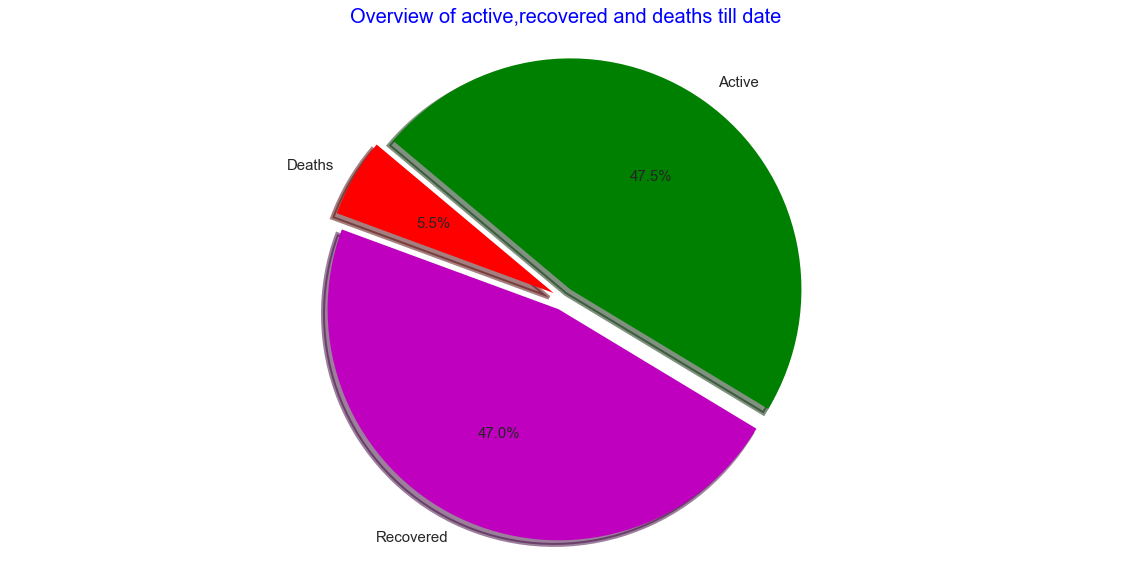

In [121]:
size=Total['Values'][1:]
label=Total['Variable'][1:]
color=['r','m','g']
plt.figure(figsize=(20,10))
plt.pie(size, explode=[0.05,0.05,0.05], labels=label,colors=color,
autopct='%1.1f%%', shadow=True, startangle=140, textprops={'fontsize': 15},wedgeprops={'linewidth': 4})
plt.title('Overview of active,recovered and deaths till date',fontsize=20,color='b')
plt.axis('equal')
plt.show()


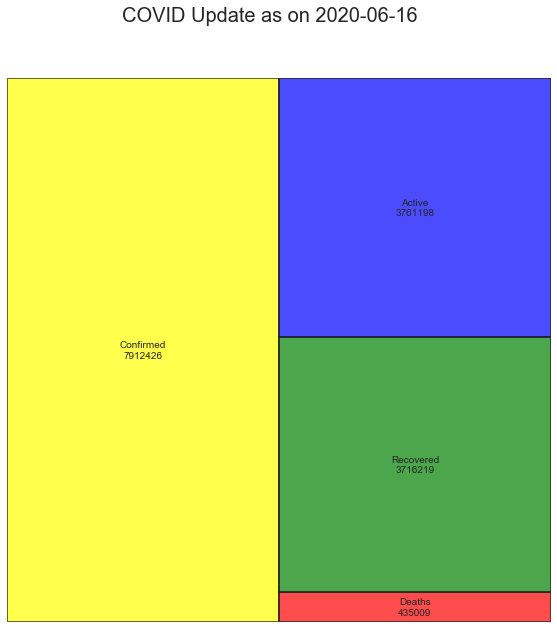

In [122]:
!pip install squarify
import squarify
labels=[]
for i,j in zip(Total['Variable'],Total['Values']):
    k=str(i)+'\n'+str(j)
    labels.append(k)
fig = plt.figure(figsize=(10, 10))
fig.suptitle('COVID Update as on '+str(date.today()), fontsize=20)
ax = fig.add_subplot(111, aspect="equal")
ax=squarify.plot(sizes=Total['Values'], label=labels,
              color=['yellow','red','green','blue'], alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
plt.axis('off')
plt.rc('font', size=15)
plt.show()


<Figure size 1080x2160 with 0 Axes>

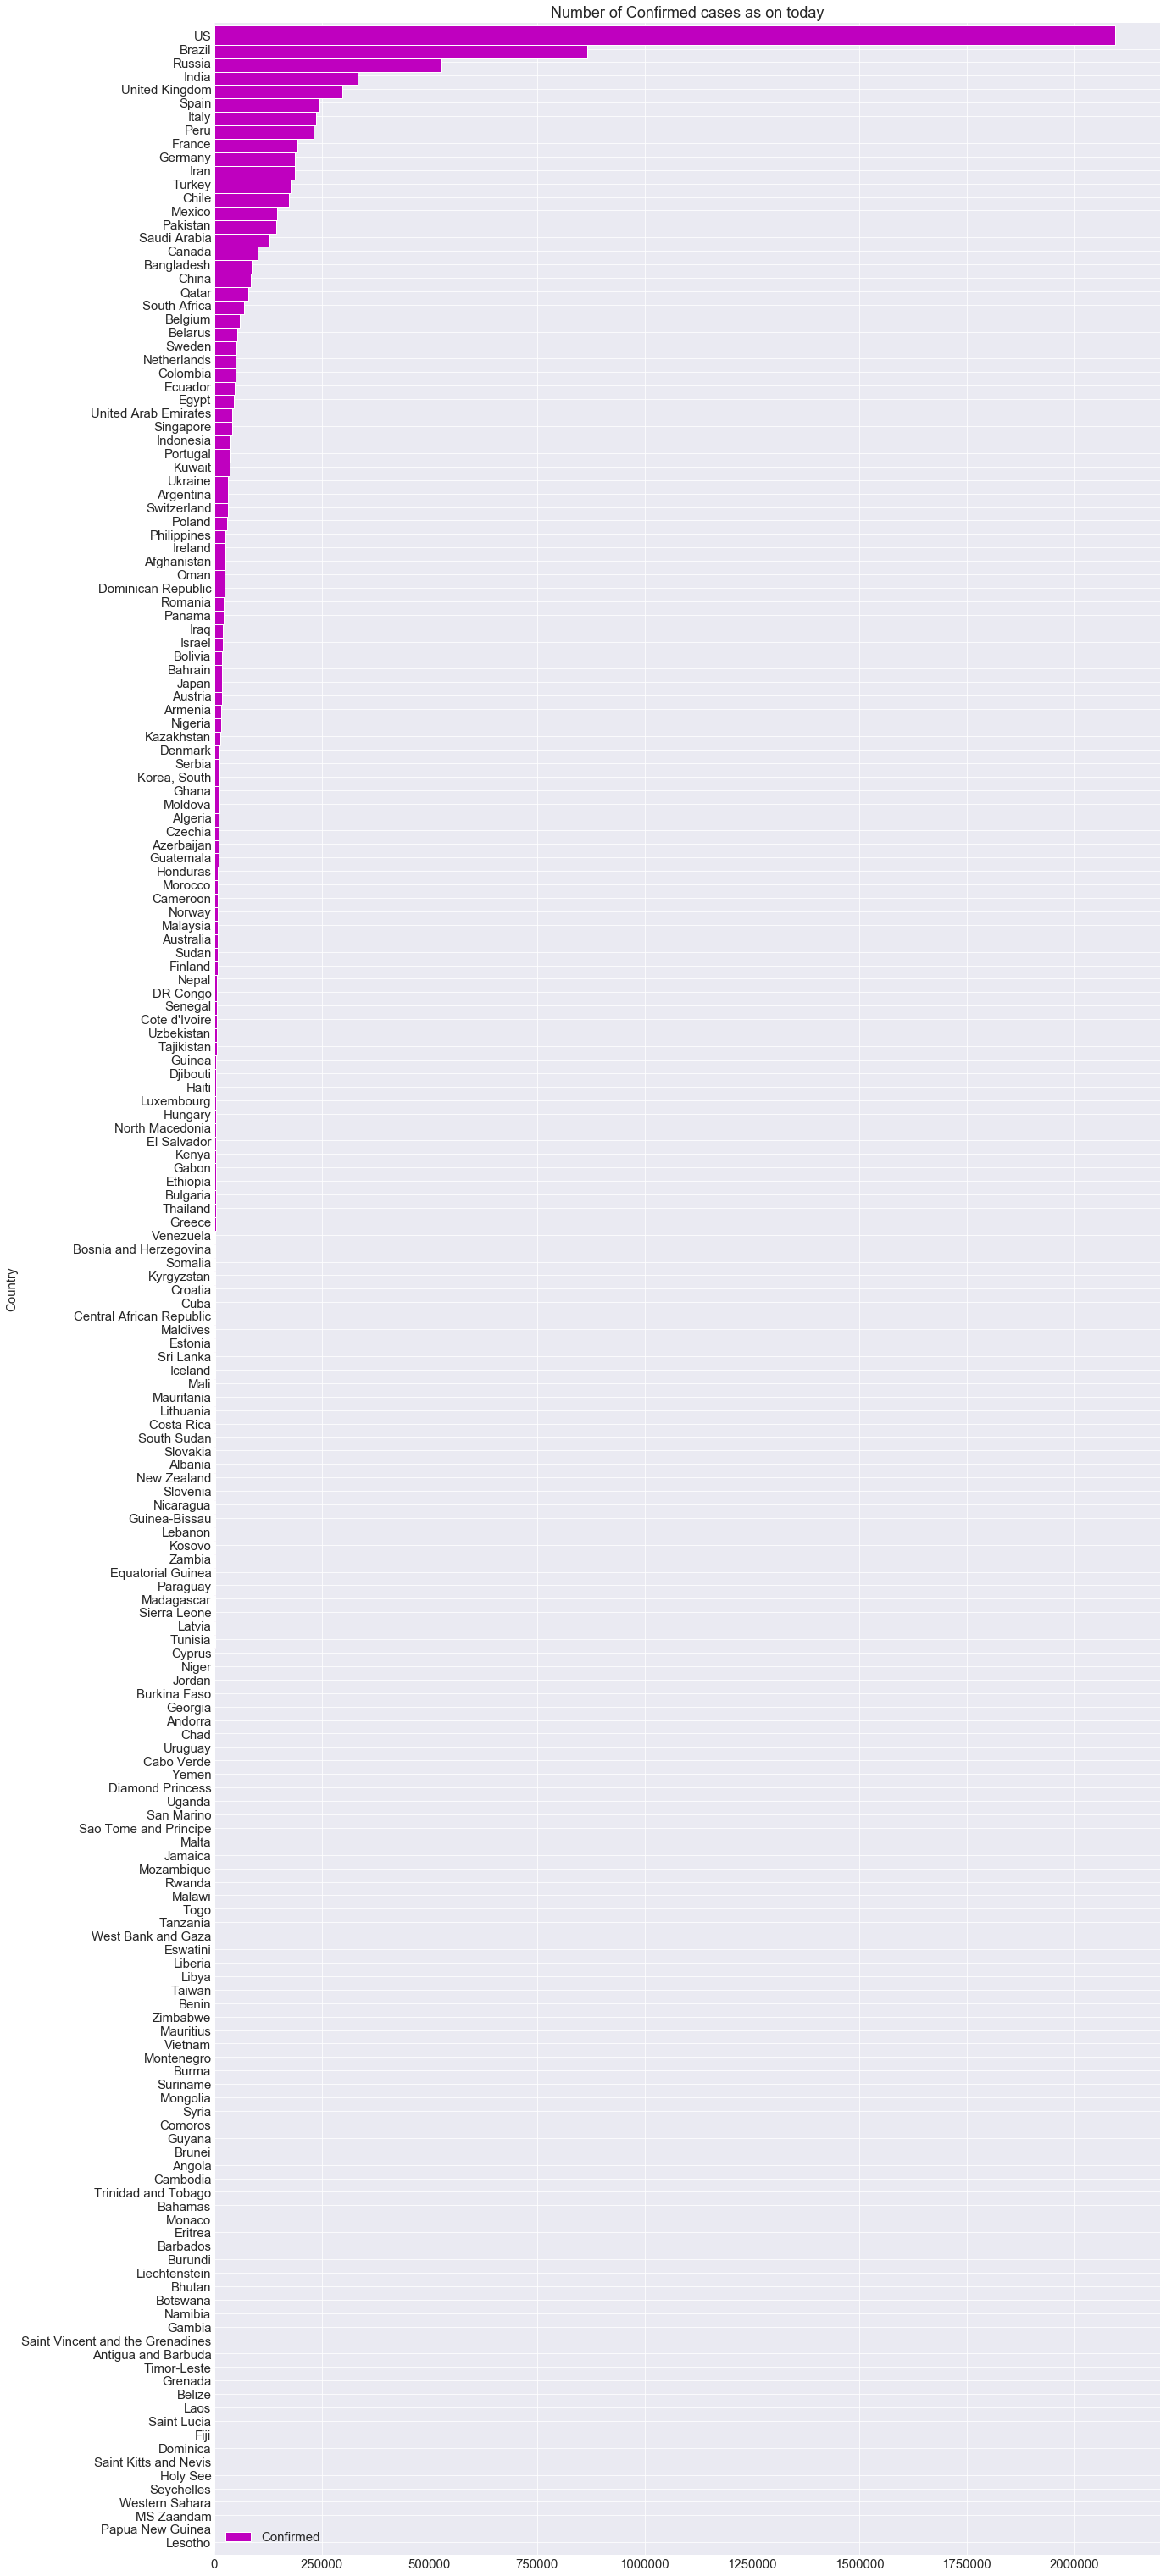

In [123]:
plt.style.use('seaborn-darkgrid')
plt.figure(figsize=(15,30))
Data_recent=Data_recent.sort_values(by=['Confirmed'])

Data_recent.plot.barh( x="Country",y="Confirmed",width=1.4,figsize=(20,55),color='m',edgecolor='white',title="Number of Confirmed cases as on today");
plt.show()

US with highest number of Covid cases and India in 7th position as on Jun 1st 2020

Removing countries with 0 confirmed cases from our dataset as these can be considered as unaffected countries


In [124]:
least_affected=Data_recent[Data_recent['Confirmed']<10000]['Country'] ##

In [125]:
print(least_affected.values)

['Lesotho' 'Papua New Guinea' 'MS Zaandam' 'Western Sahara' 'Seychelles'
 'Holy See' 'Saint Kitts and Nevis' 'Dominica' 'Fiji' 'Saint Lucia' 'Laos'
 'Belize' 'Grenada' 'Timor-Leste' 'Antigua and Barbuda'
 'Saint Vincent and the Grenadines' 'Gambia' 'Namibia' 'Botswana' 'Bhutan'
 'Liechtenstein' 'Burundi' 'Barbados' 'Eritrea' 'Monaco' 'Bahamas'
 'Trinidad and Tobago' 'Cambodia' 'Angola' 'Brunei' 'Guyana' 'Comoros'
 'Syria' 'Mongolia' 'Suriname' 'Burma' 'Montenegro' 'Vietnam' 'Mauritius'
 'Zimbabwe' 'Benin' 'Taiwan' 'Libya' 'Liberia' 'Eswatini'
 'West Bank and Gaza' 'Tanzania' 'Togo' 'Malawi' 'Rwanda' 'Mozambique'
 'Jamaica' 'Malta' 'Sao Tome and Principe' 'San Marino' 'Uganda'
 'Diamond Princess' 'Yemen' 'Cabo Verde' 'Uruguay' 'Chad' 'Andorra'
 'Georgia' 'Burkina Faso' 'Jordan' 'Niger' 'Cyprus' 'Tunisia' 'Latvia'
 'Sierra Leone' 'Madagascar' 'Paraguay' 'Equatorial Guinea' 'Zambia'
 'Kosovo' 'Lebanon' 'Guinea-Bissau' 'Nicaragua' 'Slovenia' 'New Zealand'
 'Albania' 'Slovakia' 'South Sudan

In [126]:
Data_recent.shape

(187, 10)

In [198]:
import matplotlib.colors as mcolors
def composition_cases(Data,typ):
    fig = plt.figure(figsize=(20, 20))
    fig.suptitle('COVID '+str(typ)+' cases as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
     #plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


In [128]:
def composition_case_top20(Data,typ):
    fig = plt.figure(figsize=(16, 16))
    fig.suptitle('COVID '+str(typ)+' top 20 countries as on '+str(date.today()), fontsize=20)
    ax = fig.add_subplot(111, aspect="equal")
   
    Data = Data[Data[typ]>0]
    Data = Data.sort_values(typ).tail(20)
    labels=[]
    for i,j in zip(Data['Country'],Data[typ]):
        k=str(i)+'\n'+str(j)
        labels.append(k)
    ax=squarify.plot(sizes=Data[typ], label=labels,color=mcolors.CSS4_COLORS , alpha=0.7, bar_kwargs=dict(linewidth=2, edgecolor="#222222"))
    plt.axis('off')
    plt.rc('font', size=10)
    plt.show()
    plt.tight_layout()


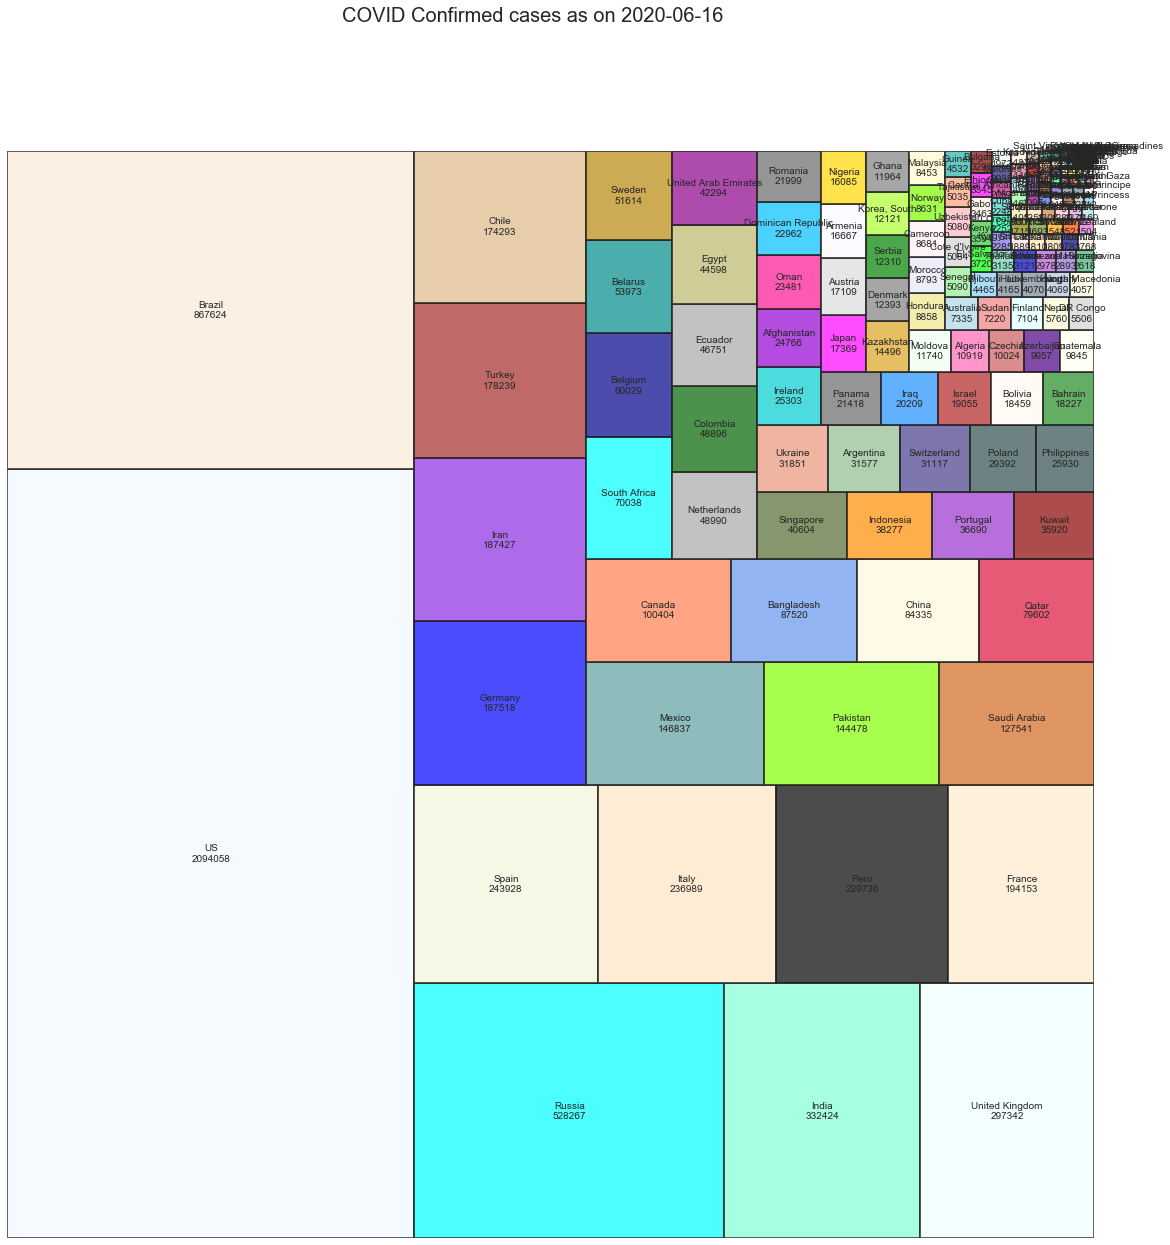

<Figure size 432x288 with 0 Axes>

In [199]:
composition_cases(Data_recent,'Confirmed')

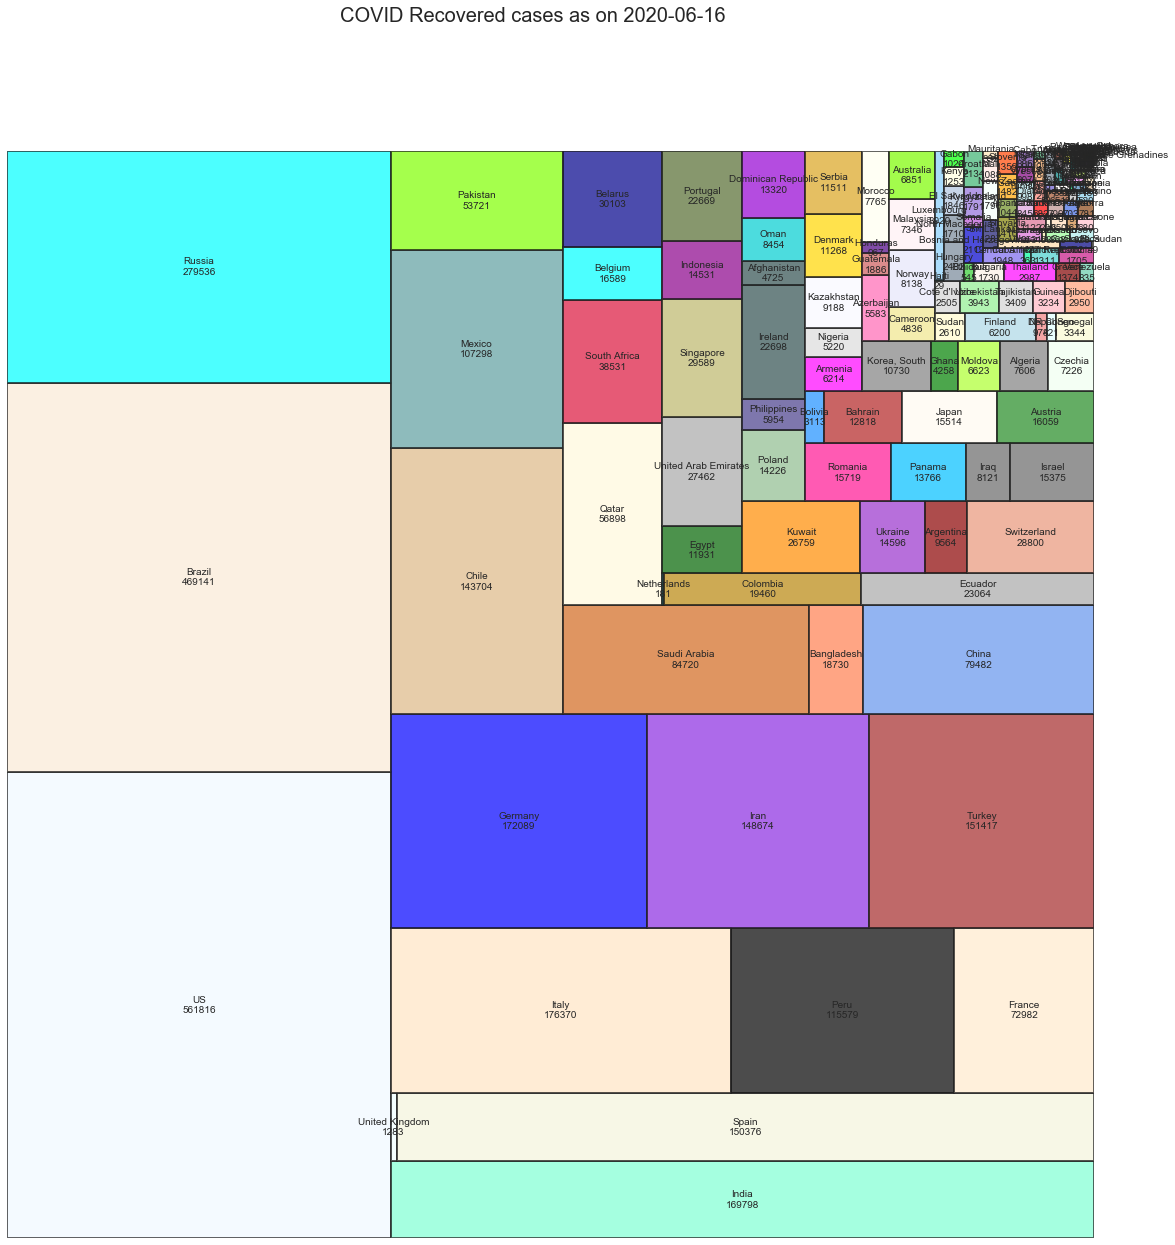

<Figure size 432x288 with 0 Axes>

In [200]:
composition_cases(Data_recent,'Recovered')

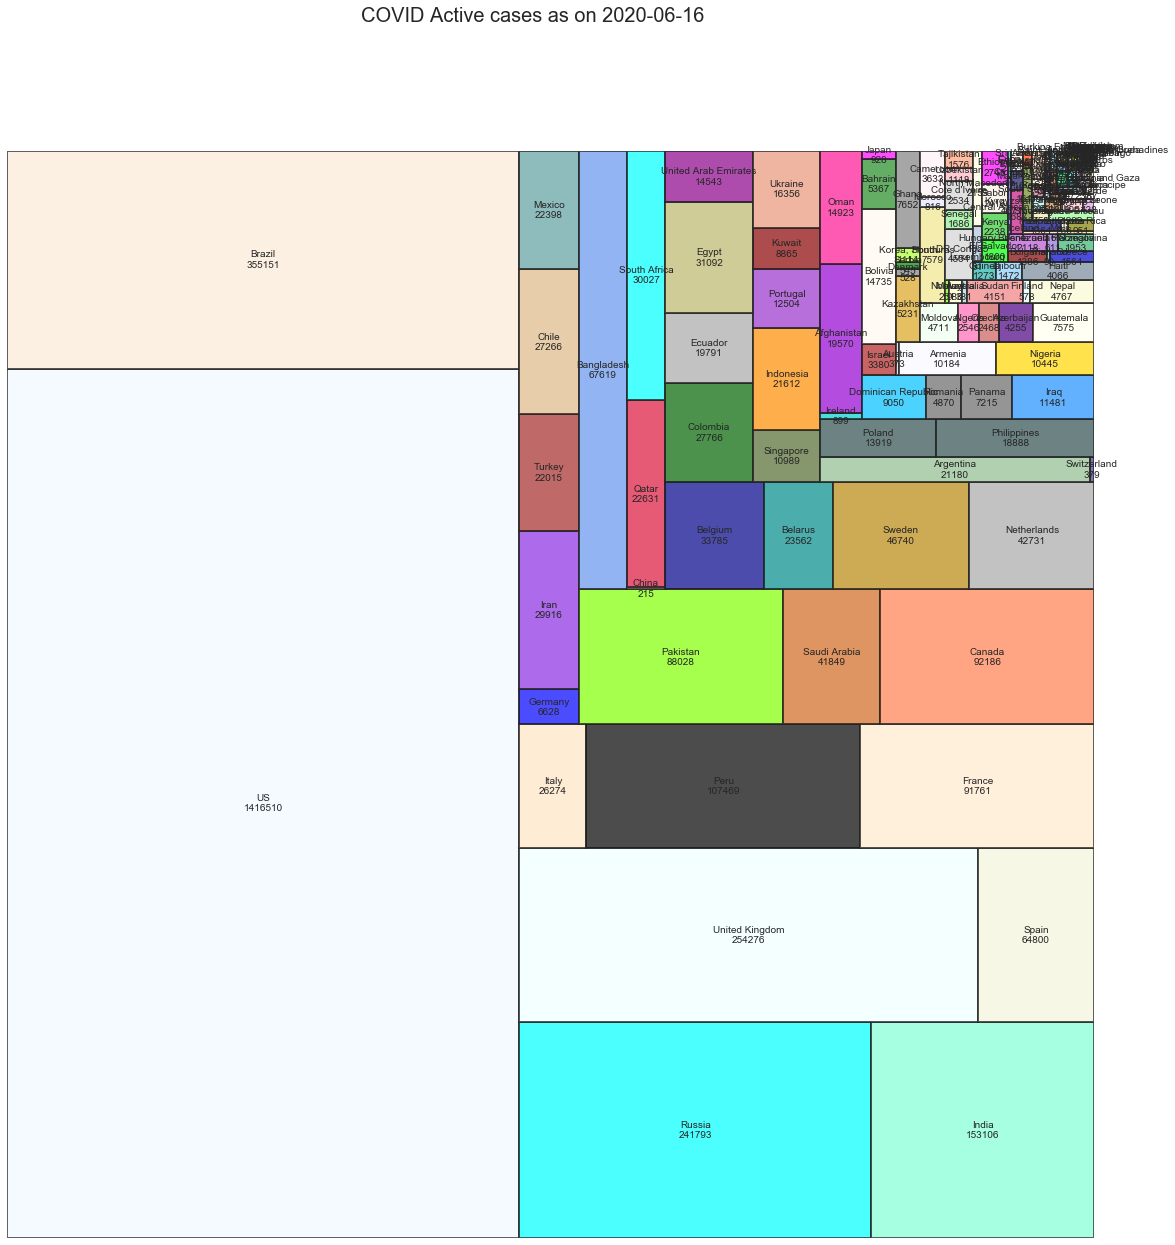

<Figure size 432x288 with 0 Axes>

In [201]:
composition_cases(Data_recent,'Active')

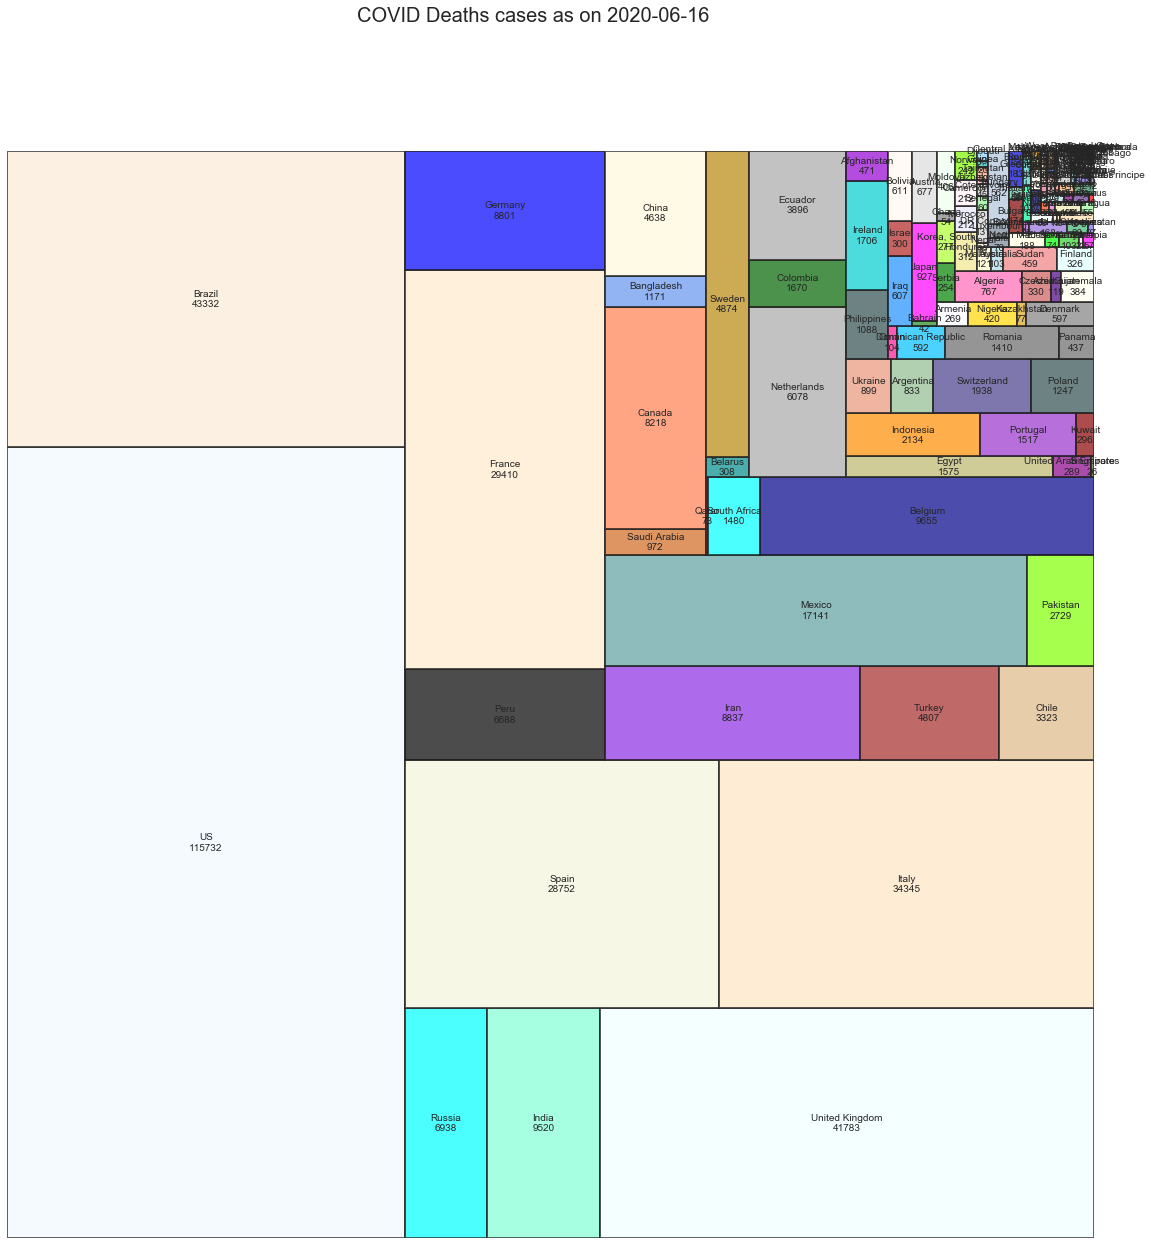

<Figure size 432x288 with 0 Axes>

In [202]:
composition_cases(Data_recent,'Deaths')

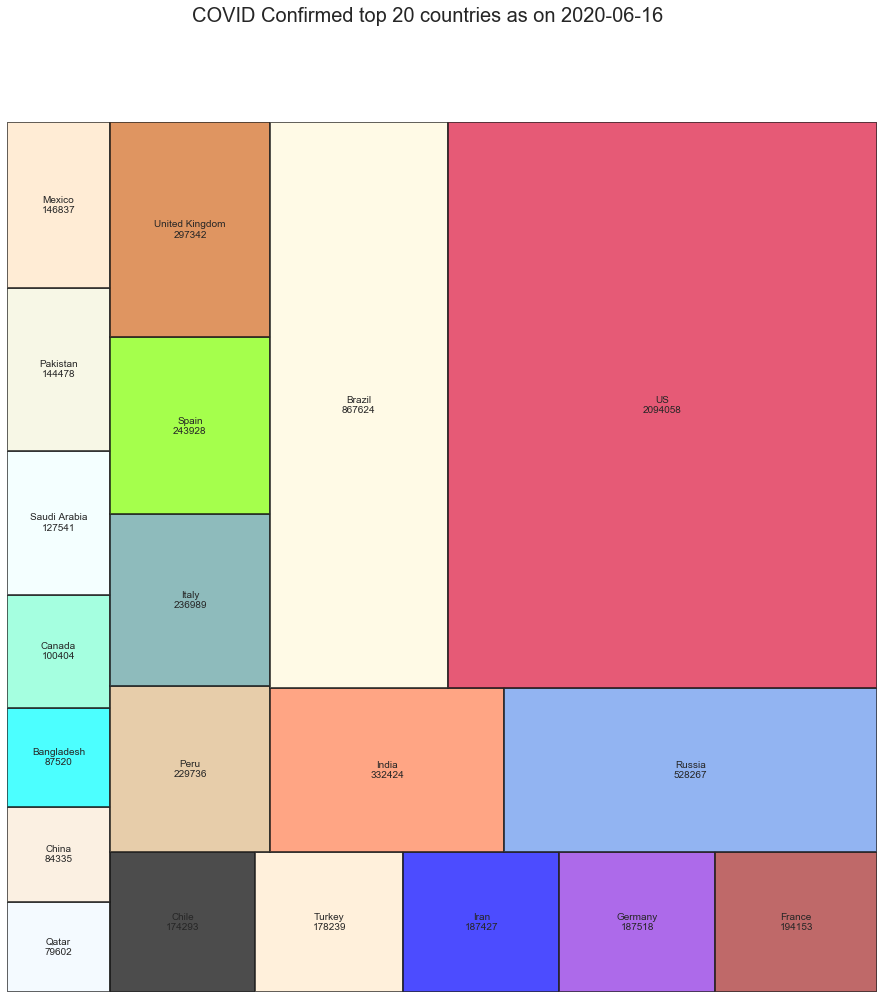

<Figure size 432x288 with 0 Axes>

In [133]:
composition_case_top20(Data_recent,'Confirmed')

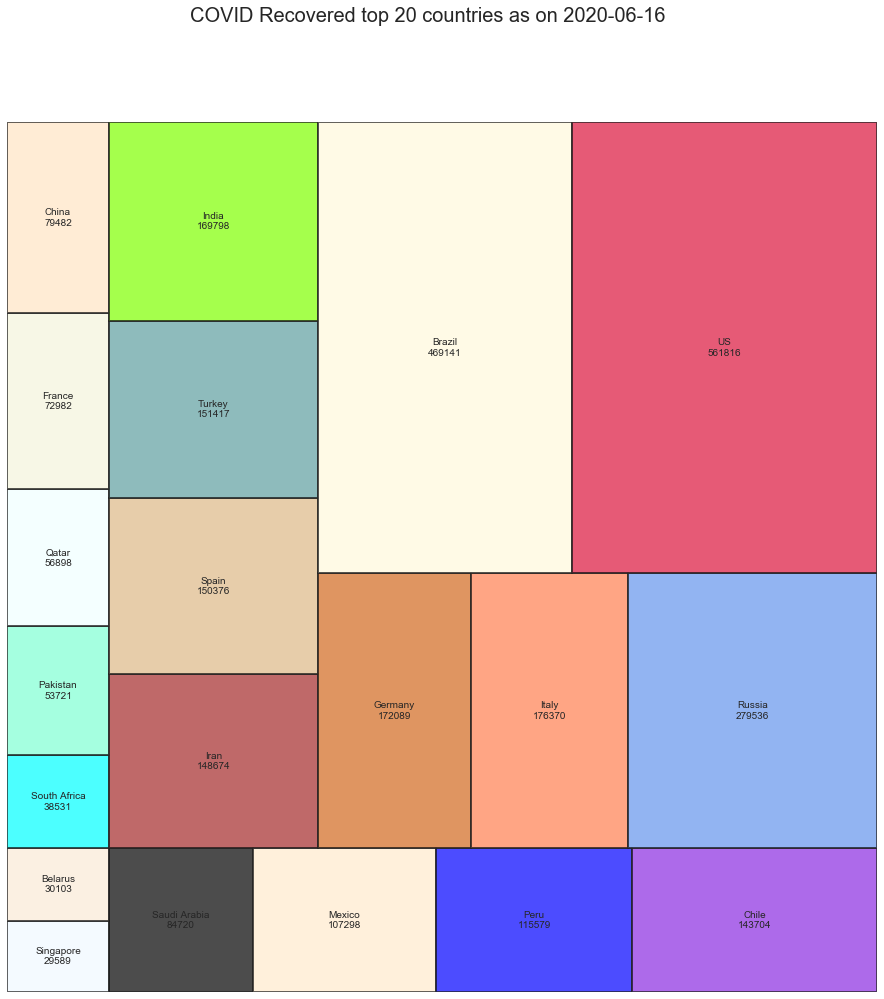

<Figure size 432x288 with 0 Axes>

In [134]:
composition_case_top20(Data_recent,'Recovered')

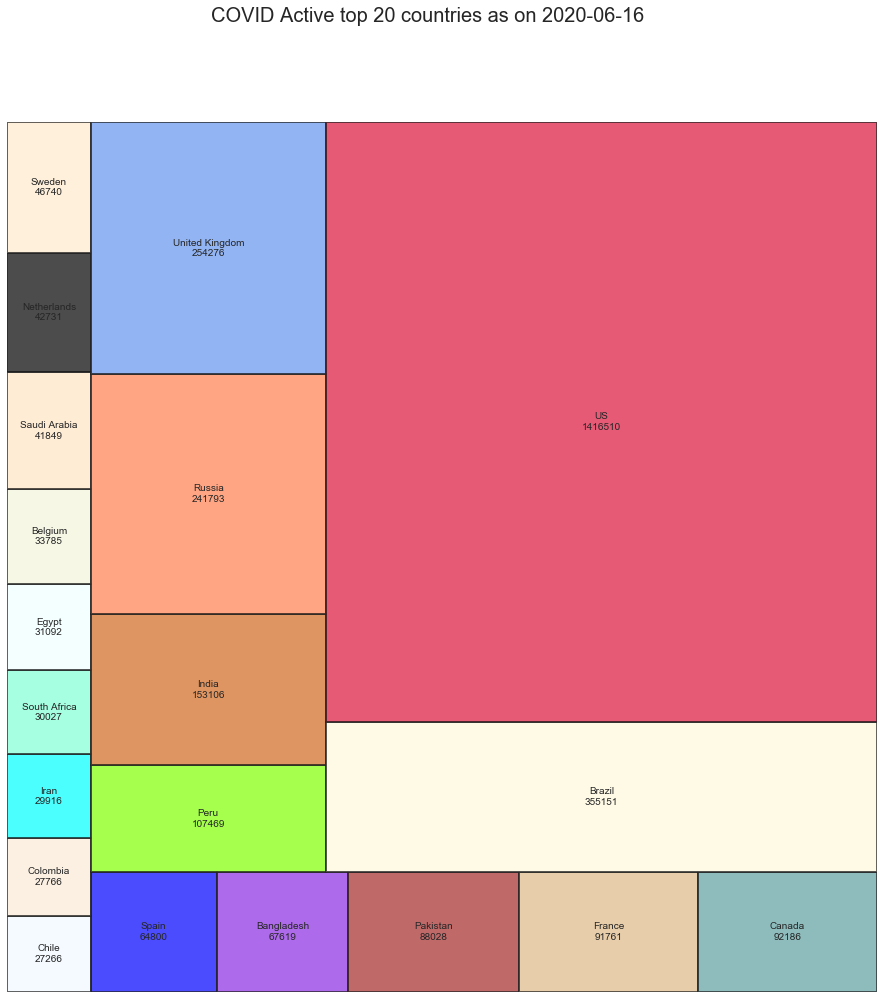

<Figure size 432x288 with 0 Axes>

In [135]:
composition_case_top20(Data_recent,'Active')

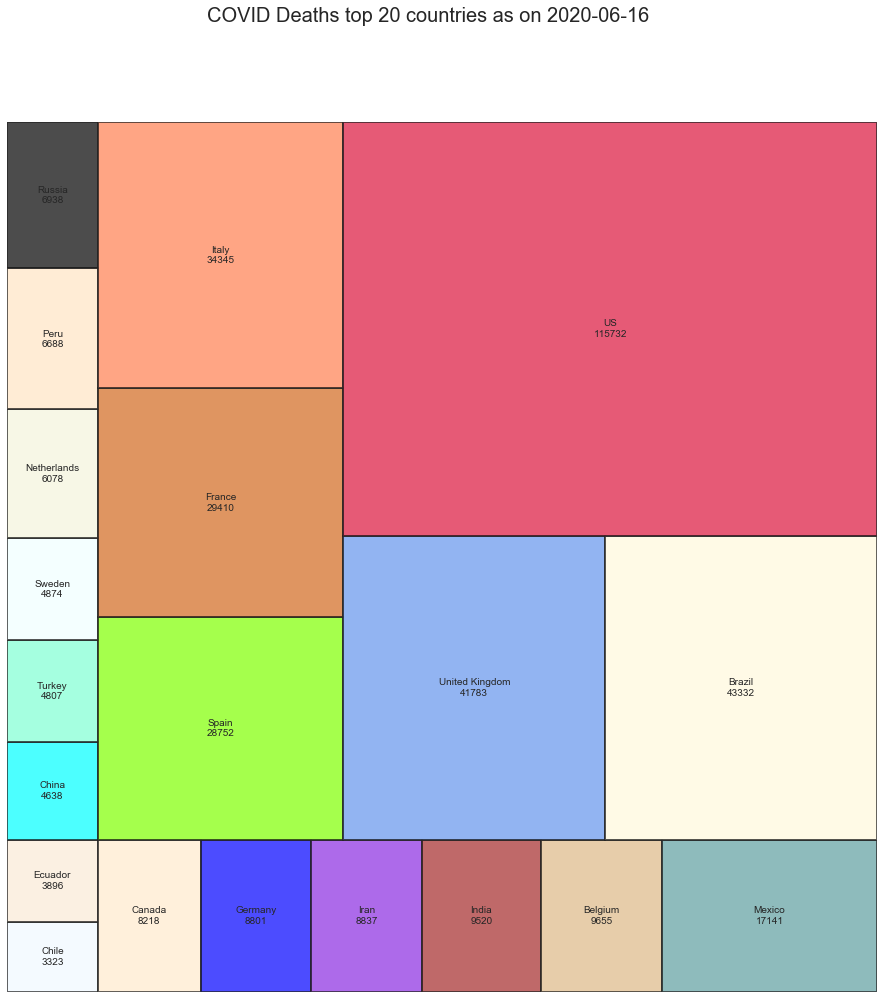

<Figure size 432x288 with 0 Axes>

In [136]:
composition_case_top20(Data_recent,'Deaths')

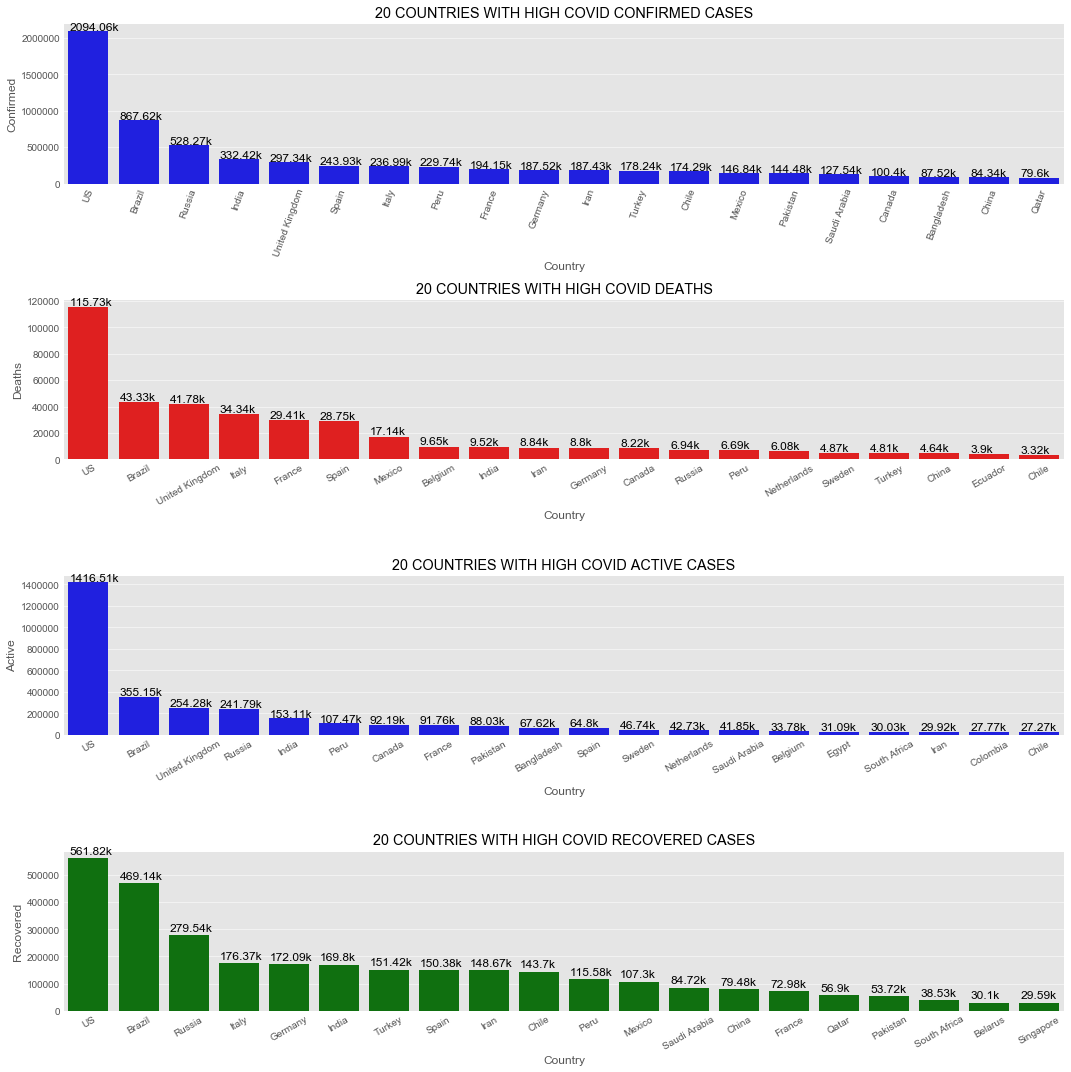

In [260]:
f, axes = plt.subplots(4, 1, figsize=(15, 15))

ax1=sns.barplot(x='Country',y='Confirmed',data= Data_recent.sort_values(by=['Confirmed'],ascending=False).head(20),color='blue',ax=axes[0])
plt.setp(axes[0].get_xticklabels(),visible=True, rotation=70)
ax1.set_title("20 COUNTRIES WITH HIGH COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax2=sns.barplot(x='Country',y='Deaths',data= Data_recent.sort_values(by=['Deaths'],ascending=False).head(20),color='red',ax=axes[1])
plt.setp(axes[1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_x()+.02, i.get_height()+1500,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax3=sns.barplot(x='Country',y='Active',data= Data_recent.sort_values(by=['Active'],ascending=False).head(20),color='blue',ax=axes[2])
plt.setp(axes[2].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
    
ax4=sns.barplot(x='Country',y='Recovered',data= Data_recent.sort_values(by=['Recovered'],ascending=False).head(20),color='green',ax=axes[3])
plt.setp(axes[3].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_x()+.02, i.get_height()+15000,str(round((i.get_height()/1000), 2))+'k', fontsize=12,color='black')
ax4.set_title("20 COUNTRIES WITH HIGH COVID RECOVERED CASES")
plt.tight_layout()

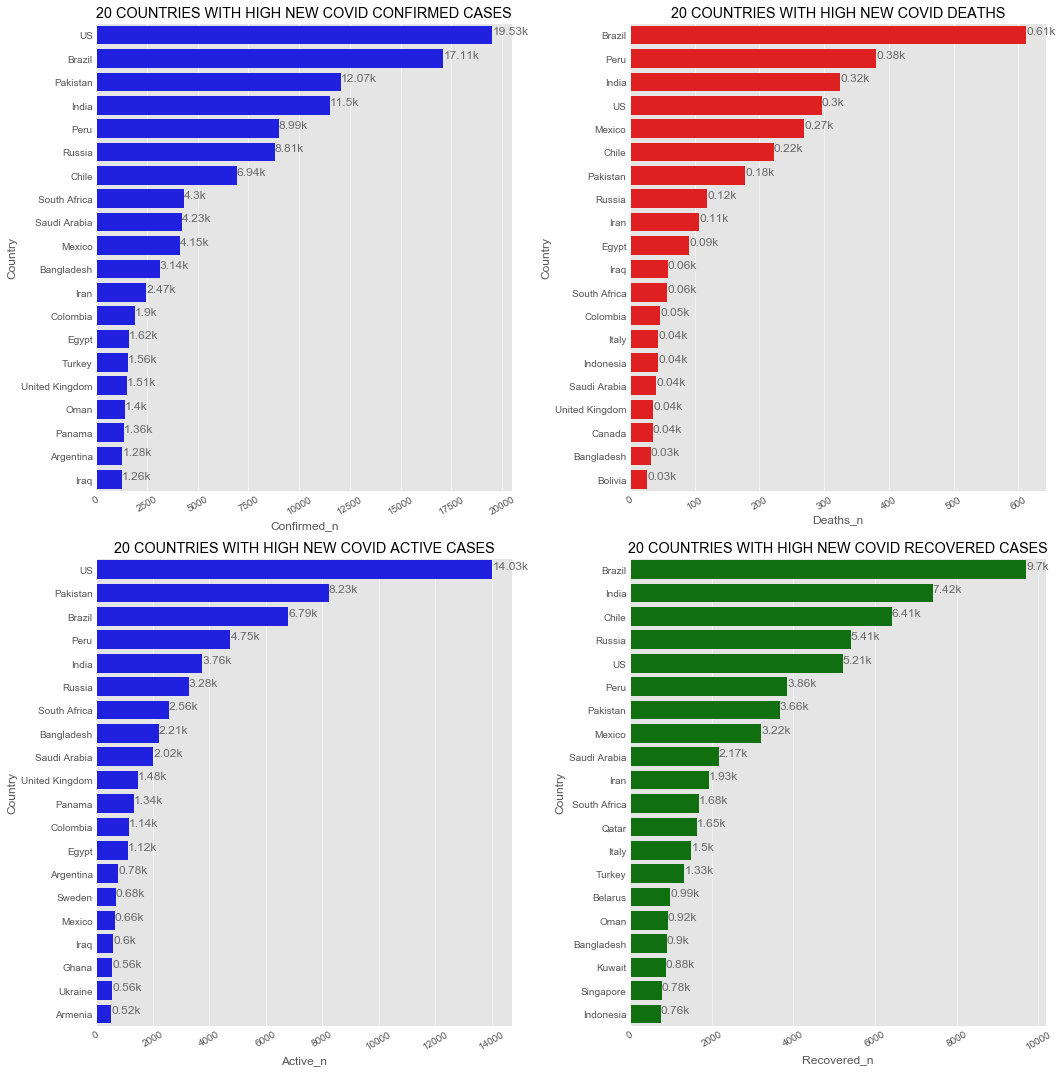

In [261]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed_n',y='Country',data= Data_recent.sort_values(by=['Confirmed_n'],ascending=False).head(20),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("20 COUNTRIES WITH HIGH NEW COVID CONFIRMED CASES")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_n',y='Country',data= Data_recent.sort_values(by=['Deaths_n'],ascending=False).head(20),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("20 COUNTRIES WITH HIGH NEW COVID DEATHS")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_n',y='Country',data= Data_recent.sort_values(by=['Active_n'],ascending=False).head(20),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("20 COUNTRIES WITH HIGH NEW COVID ACTIVE CASES")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_n',y='Country',data= Data_recent.sort_values(by=['Recovered_n'],ascending=False).head(20),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("20 COUNTRIES WITH HIGH NEW COVID RECOVERED CASES")
plt.tight_layout()

In [139]:
Data_recent[Data_recent['Country']=='US']

Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
25229      US 2020-06-14    2094058  115732     561816        19532       296   

       Recovered_n   Active  Active_n  
25229         5210  1416510     14026

In [140]:
Data_recent['Deathrate']= round(Data_recent['Deaths']/Data_recent['Confirmed']*100,2)
Data_recent['Recoveryrate']= round(Data_recent['Recovered']/Data_recent['Confirmed']*100,2)
Data_recent.sort_values(by=['Confirmed'],ascending=False,inplace=True)
Data_recent.head()

Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
25229              US 2020-06-14    2094058  115732     561816        19532   
3479           Brazil 2020-06-14     867624   43332     469141        17110   
20299          Russia 2020-06-14     528267    6938     279536         8809   
11454           India 2020-06-14     332424    9520     169798        11502   
25809  United Kingdom 2020-06-14     297342   41783       1283         1514   

       Deaths_n  Recovered_n   Active  Active_n  Deathrate  Recoveryrate  
25229       296         5210  1416510     14026       5.53         26.83  
3479        612         9705   355151      6793       4.99         54.07  
20299       119         5408   241793      3282       1.31         52.92  
11454       325         7419   153106      3758       2.86         51.08  
25809        36            0   254276      1478      14.05          0.43

In [141]:
Most_affected=Data_recent[Data_recent['Confirmed']>100000]

In [146]:

print(Most_affected.shape)
Most_affected.style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_n"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_n"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_n"])\
                        .background_gradient(cmap='YlOrBr',subset=["Active_n"])\
                        .background_gradient(cmap='spring',subset=["Deathrate"])\
                        .background_gradient(cmap='summer',subset=["Recoveryrate"])

(17, 12)


13 countries with more than one lakh affected cases are found. furthur analysis on these countries would be done

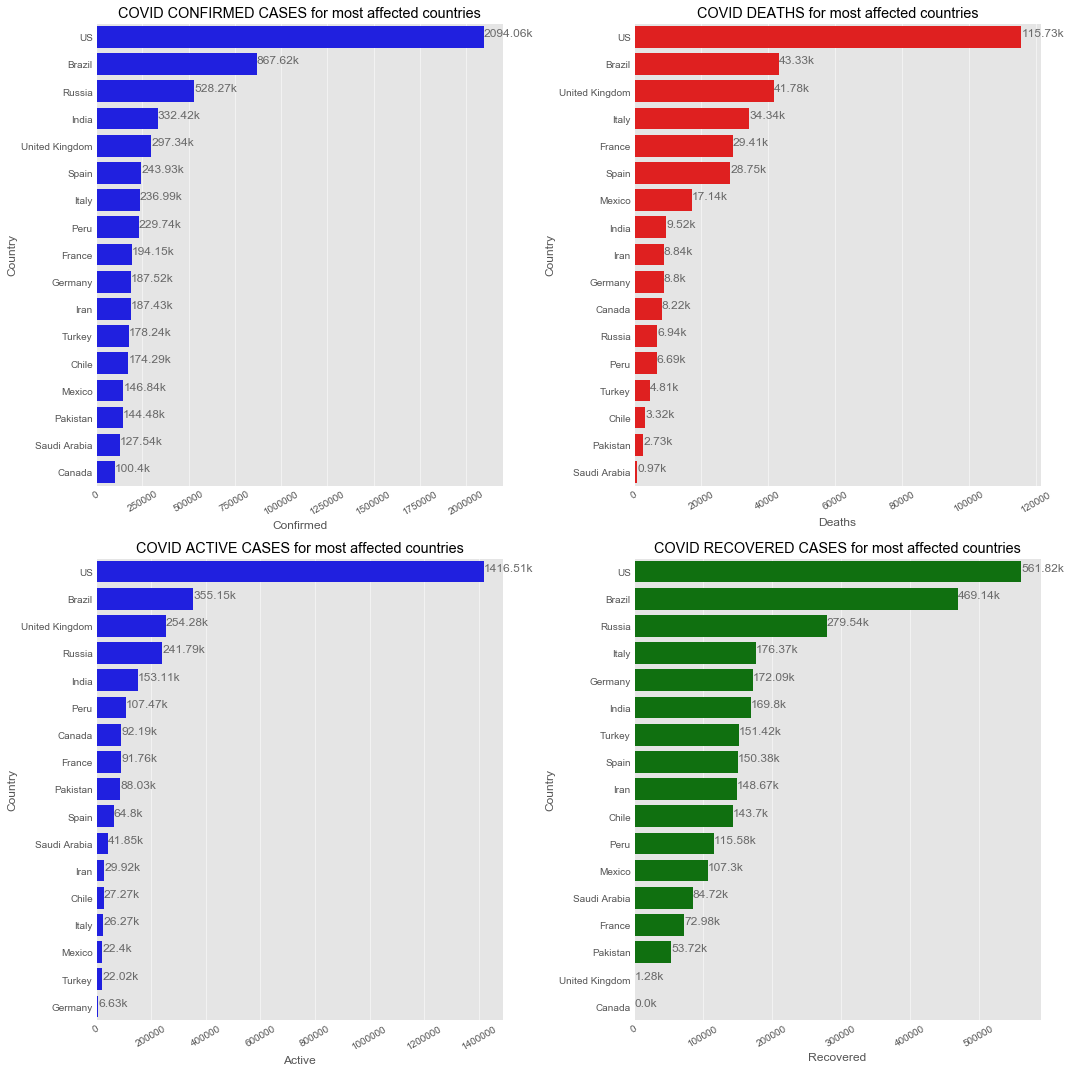

In [262]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed',y='Country',data= Most_affected.sort_values(by=['Confirmed'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES for most affected countries")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths',y='Country',data= Most_affected.sort_values(by=['Deaths'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATHS for most affected countries")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active',y='Country',data= Most_affected.sort_values(by=['Active'],ascending=False),color='blue',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES for most affected countries")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered',y='Country',data= Most_affected.sort_values(by=['Recovered'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,str(round((i.get_width()/1000), 2))+'k', fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES for most affected countries")
plt.tight_layout()

In [148]:
Most_affected[Most_affected['Country']=='US']

Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
25229      US 2020-06-14    2094058  115732     561816        19532       296   

       Recovered_n   Active  Active_n  Deathrate  Recoveryrate  
25229         5210  1416510     14026       5.53         26.83

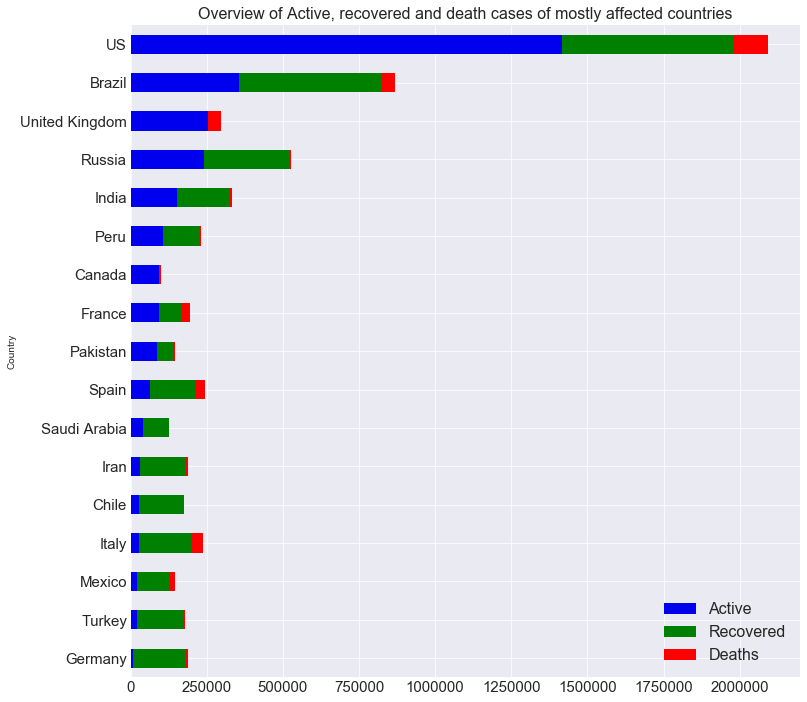

In [149]:

color=['#0000EE','green','red'] 
Most_affected = Most_affected.sort_values(by=['Confirmed'])
x=Most_affected[['Country','Active','Recovered','Deaths']]
y=x.set_index('Country')
z=y.groupby('Country').sum().sort_values(by=['Active'])
f=z.plot.barh(color=color,stacked=True,figsize=(12,12),fontsize=15,title='Overview of Active, recovered and death cases of mostly affected countries')
plt.legend(loc=4, prop={'size': 16})
f.title.set_fontsize(16)

Recovery rate is quite low in some countries.From the plot its evident that Germany has better recovery rate than other most affected countries.lets have a look at death rate and recovery rate in each country.

In [150]:
# Plotting Top 15 countries with best recovery rate and highest death rate 

In [151]:
#f, axes = plt.subplots(1,2,figsize=(15, 15), sharex=True)
r= Data_recent[['Country','Recoveryrate','Confirmed']].sort_values(by=['Recoveryrate']).tail(15)
r

Country  Recoveryrate  Confirmed
16239              Mauritius         96.44        337
14934             Luxembourg         96.54       4070
26389                Vietnam         96.71        334
16964             Montenegro         96.92        325
23924                 Taiwan         97.29        443
4494                Cambodia         97.66        128
3624                  Brunei         97.87        141
17834            New Zealand         98.54       1504
11309                Iceland         99.23       1810
21749             Seychelles        100.00         11
19139       Papua New Guinea        100.00          8
20589  Saint Kitts and Nevis        100.00         15
13774                   Laos        100.00         19
10874               Holy See        100.00         12
8699                    Fiji        100.00         18

In [152]:
#Lowest death rate
d=Data_recent[['Country','Deathrate']].sort_values(by=['Deathrate']).head(15)
d

Country  Deathrate
14209                           Lesotho        0.0
4494                           Cambodia        0.0
2899                             Bhutan        0.0
16819                          Mongolia        0.0
19139                  Papua New Guinea        0.0
17399                           Namibia        0.0
20879  Saint Vincent and the Grenadines        0.0
8119                            Eritrea        0.0
10004                           Grenada        0.0
13774                              Laos        0.0
20734                       Saint Lucia        0.0
24504                       Timor-Leste        0.0
10874                          Holy See        0.0
26389                           Vietnam        0.0
21749                        Seychelles        0.0

In [153]:
#Most_affected['Deathrate']= round(Most_affected['Deaths']/Most_affected['Confirmed']*100,2)
#Most_affected['Recoveryrate']= round(Most_affected['Recovered']/Most_affected['Confirmed']*100,2)
Most_affected.sort_values(by=['Confirmed'],ascending=False,inplace=True)
Most_affected.head()



Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
25229              US 2020-06-14    2094058  115732     561816        19532   
3479           Brazil 2020-06-14     867624   43332     469141        17110   
20299          Russia 2020-06-14     528267    6938     279536         8809   
11454           India 2020-06-14     332424    9520     169798        11502   
25809  United Kingdom 2020-06-14     297342   41783       1283         1514   

       Deaths_n  Recovered_n   Active  Active_n  Deathrate  Recoveryrate  
25229       296         5210  1416510     14026       5.53         26.83  
3479        612         9705   355151      6793       4.99         54.07  
20299       119         5408   241793      3282       1.31         52.92  
11454       325         7419   153106      3758       2.86         51.08  
25809        36            0   254276      1478      14.05          0.43

Text(0.5, 1.0, 'Recovery rate of most affected countries ')

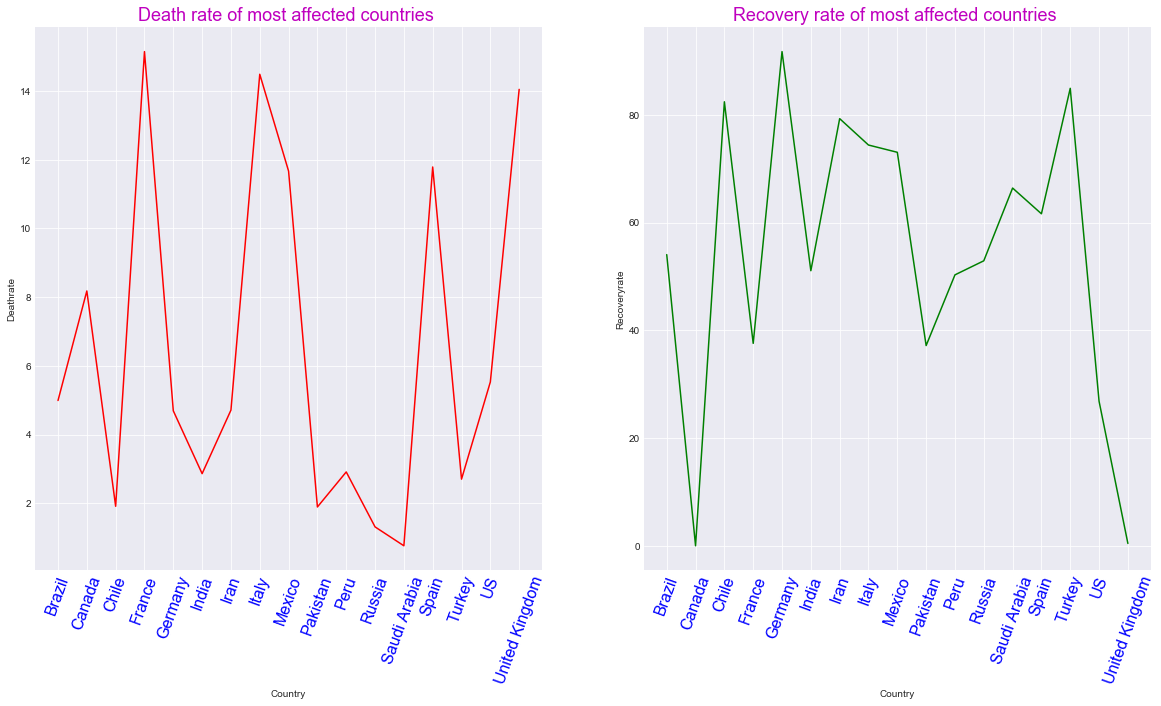

In [154]:
plt.figure(figsize=(20,10))
plt.style.use('seaborn-darkgrid')
plt.subplot(1, 2, 1)
ax1=sns.lineplot(x='Country',y='Deathrate',data=Most_affected,color='red')
ax1.set_title('Death rate of most affected countries ',fontsize=18,color='m')
plt.xticks(fontsize=16,color='blue')
plt.xticks(rotation=70)

plt.subplot(1, 2, 2)
ax2=sns.lineplot(x='Country',y='Recoveryrate',data=Most_affected,color='green')
plt.xticks(rotation=70)
plt.xticks(fontsize=16,color='blue')

ax2.set_title('Recovery rate of most affected countries ',fontsize=18,color='m')

Lets have a look at temporial analysis of covid cases 


188 countries with data from 22 jun 2020 till today

How about temporial analysis of covid cases,what is the trend for most affected countries

In [155]:
timed_data = World_Data.groupby('Date').sum().reset_index()
timed_data['Deathrate']=timed_data['Deaths']/timed_data['Confirmed']*100
timed_data['Activerate']=timed_data['Active']/timed_data['Confirmed']*100
timed_data['Recoveryrate']=timed_data['Recovered']/timed_data['Confirmed']*100
timed_data.head()



Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
0 2020-01-22        555      17         28          555        17   
1 2020-01-23        654      18         30           99         1   
2 2020-01-24        941      26         36          287         8   
3 2020-01-25       1434      42         39          493        16   
4 2020-01-26       2118      56         52          684        14   

   Recovered_n  Active  Active_n  Deathrate  Activerate  Recoveryrate  
0           28     510       510   3.063063   91.891892      5.045045  
1            2     606        96   2.752294   92.660550      4.587156  
2            6     879       273   2.763018   93.411265      3.825717  
3            3    1353       474   2.928870   94.351464      2.719665  
4           13    2010       657   2.644004   94.900850      2.455146

Text(0.5, 1.0, 'COVID active, recovered and death cases trend all over the world')

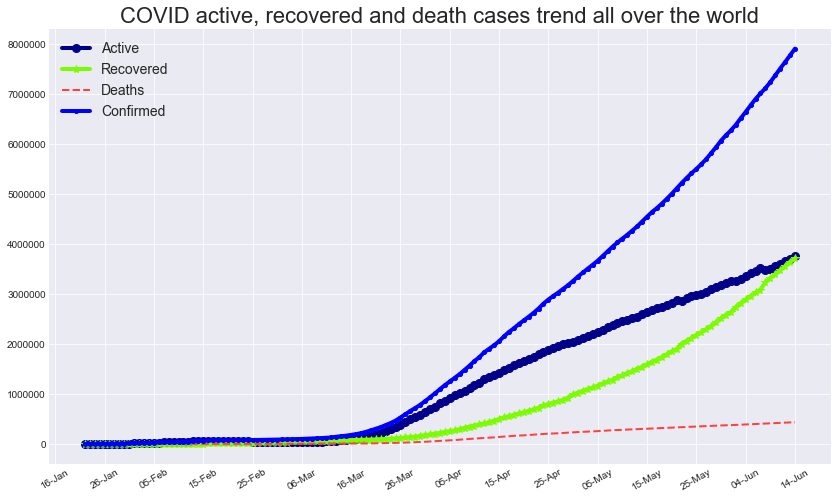

In [156]:
f,ax= plt.subplots(figsize=(14,8))
import matplotlib.ticker as ticker
#plt.figure(figsize=(14,8))
plt.style.use('seaborn-darkgrid')

plt.plot( 'Date','Active', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recovered', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deaths', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')
plt.plot( 'Date','Confirmed', data=timed_data, marker='o', color='blue',markersize=4, linewidth=4)
plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death cases trend all over the world',fontsize=22)


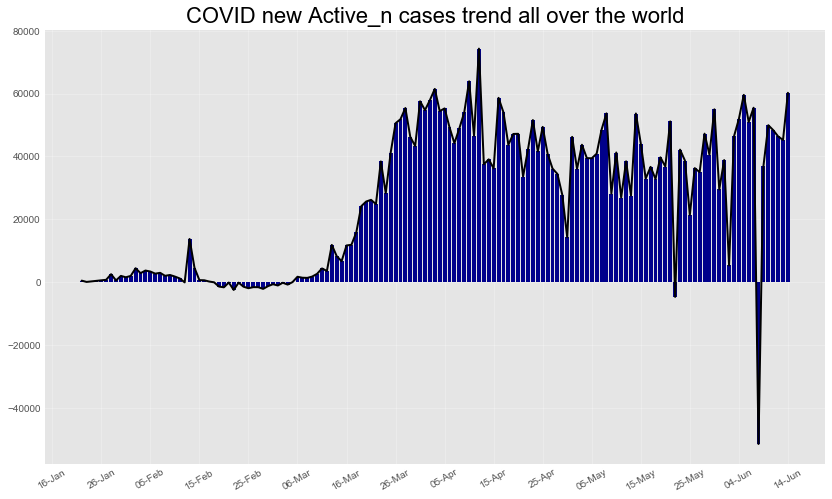

In [229]:

import matplotlib.ticker as ticker
def barplot(data,col,plot_type,color):
#plt.figure(figsize=(14,8))
    f,ax= plt.subplots(figsize=(14,8))
    plt.style.use(plot_type)

    plt.bar( 'Date',col, data=data, color=color, linewidth=4)
    plt.plot('Date',col, data=data, color='black', linewidth=2)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    plt.grid(linewidth=0.5,alpha=0.5)
    plt.title('COVID new '+str(col)+' cases trend all over the world',fontsize=22)
barplot(timed_data,'Active_n','ggplot','#00008B')

In [225]:
#Huge reduction in active cases on 8th june is observed --This is due to missing recovery information in 'Brazil' which shows around 1 lakh recoveries in one day
print(timed_data[timed_data['Date']=='2020-06-08'])
World_Data[(World_Data['Date']=='2020-06-08')&(World_Data['Country']=='Brazil')]

          Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
138 2020-06-08    7120423  408217    3238012       103378      3744   

     Recovered_n   Active  Active_n  Deathrate  Activerate  Recoveryrate  
138       151081  3474194    -51447   5.733044   48.791961     45.474995  


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  Deaths_n  \
3473  Brazil 2020-06-08     707412   37134     378257        15654       679   

      Recovered_n  Active  Active_n  
3473        94305  292021    -79330

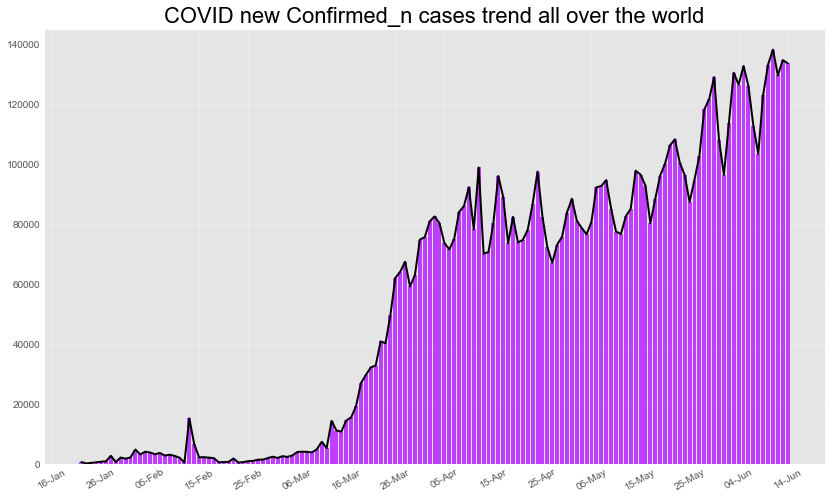

In [230]:
barplot(timed_data,'Confirmed_n','ggplot','#BF3EFF')

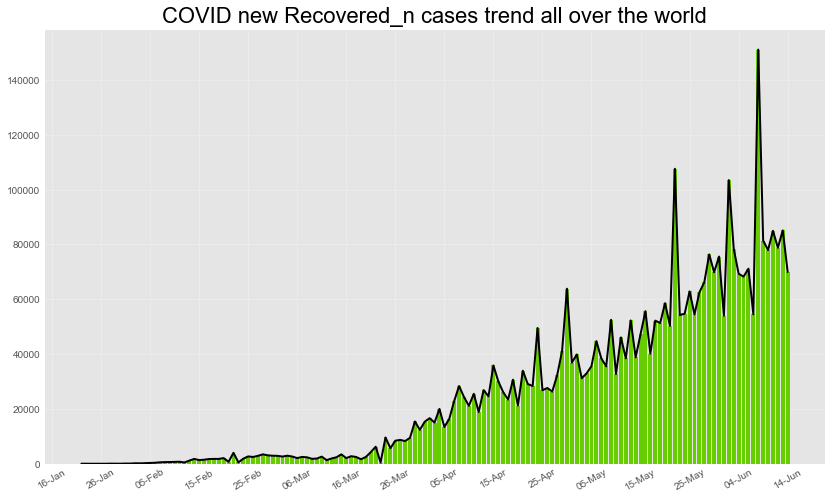

In [231]:
barplot(timed_data,'Recovered_n','ggplot','#66CD00')

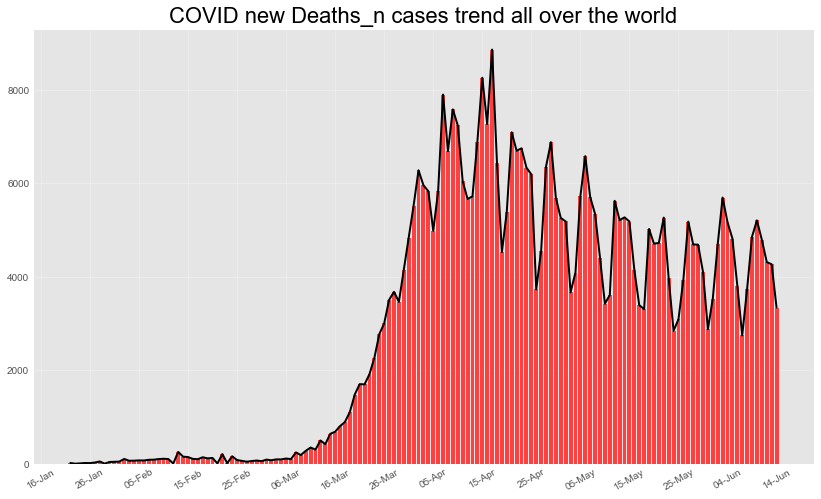

In [232]:
barplot(timed_data,'Deaths_n','ggplot','#FF4040')

Text(0.5, 1.0, 'COVID active, recovered and death rates trend all over the world')

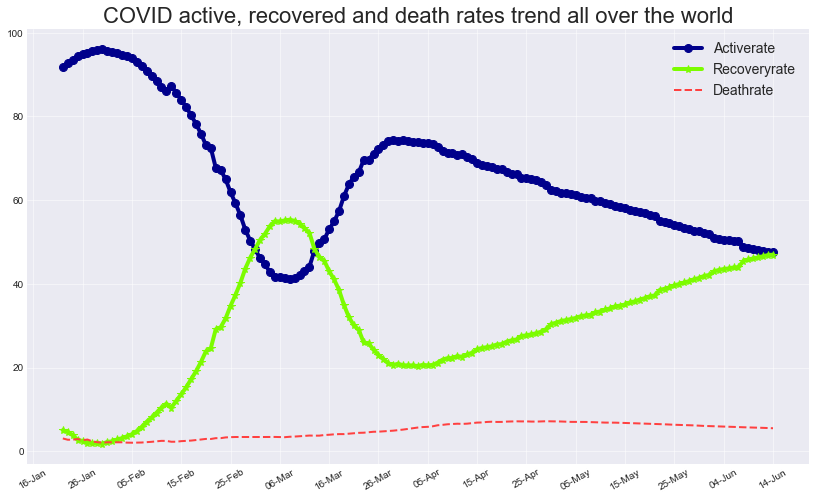

In [211]:
f,ax= plt.subplots(figsize=(14,8))

#plt.figure(figsize=(14,8))
plt.style.use('bmh')

plt.plot( 'Date','Activerate', data=timed_data, marker='o', color='#00008B',markersize=8, linewidth=4)
plt.plot( 'Date','Recoveryrate', data=timed_data, marker='*', color='#7CFC00',markersize=8, linewidth=4)
plt.plot('Date','Deathrate', data=timed_data, marker=' ', color='#FF4040', markersize=8,linewidth=2, linestyle='dashed')

plt.legend(fontsize=14)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
plt.xticks(rotation=30)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
plt.title('COVID active, recovered and death rates trend all over the world',fontsize=22)


Active cases rate has its minimum in first week of may with good recovery rate at that time, but active cases raised again till april first week beyond which downward trend is noticed. this might be because of more number of tests done in this period or infection rate raised during this period.

In [163]:
first=timed_data['Date'].min().strftime('%b%d-%Y')

now=date.today().strftime('%b%d-%Y')


In [164]:
Affected=[]
Affected=Most_affected['Country']
Affected.values


array(['US', 'Brazil', 'Russia', 'India', 'United Kingdom', 'Spain',
       'Italy', 'Peru', 'France', 'Germany', 'Iran', 'Turkey', 'Chile',
       'Mexico', 'Pakistan', 'Saudi Arabia', 'Canada'], dtype=object)

In [165]:
df_affected=World_Data[World_Data['Country'].isin(Affected)]
df_affected.shape

(2465, 10)

<Figure size 1440x1080 with 0 Axes>

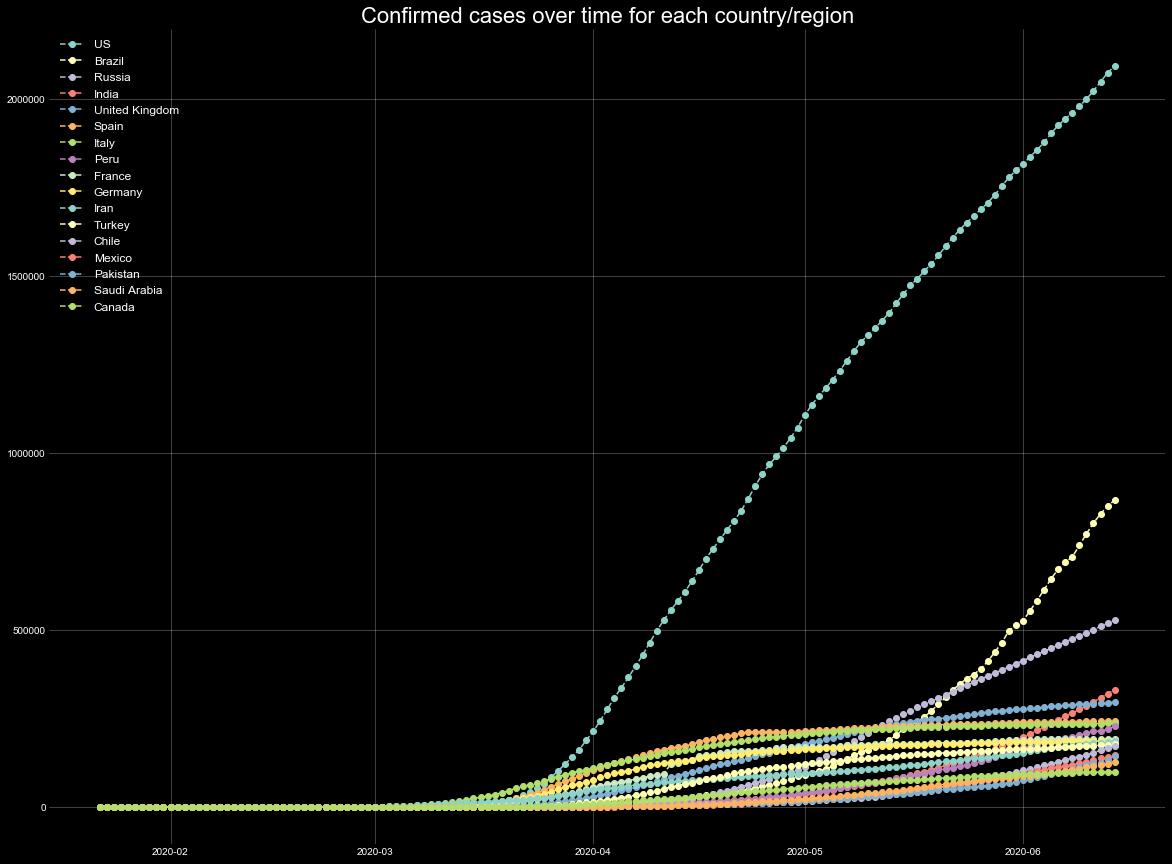

In [166]:
def plot_overtime(df_affected,col,plot_style):
    plt.style.use(plot_style)
    plt.figure(figsize=(20,15))
    fig,ax=plt.subplots(figsize=(20,15))
    for j,i in zip(Affected,range(len(Affected))):
        plt.plot_date(y=df_affected[df_affected['Country']==j][col],x= df_affected[df_affected['Country']==j]['Date'],label = j,ls ='dashed')
    
    plt.legend(fontsize=12);
    plt.title(str(col)+' cases over time for each country/region',fontsize=22)
    plt.grid(linewidth=0.5,alpha=0.5)
plot_overtime(df_affected,'Confirmed','dark_background')

<Figure size 1440x1080 with 0 Axes>

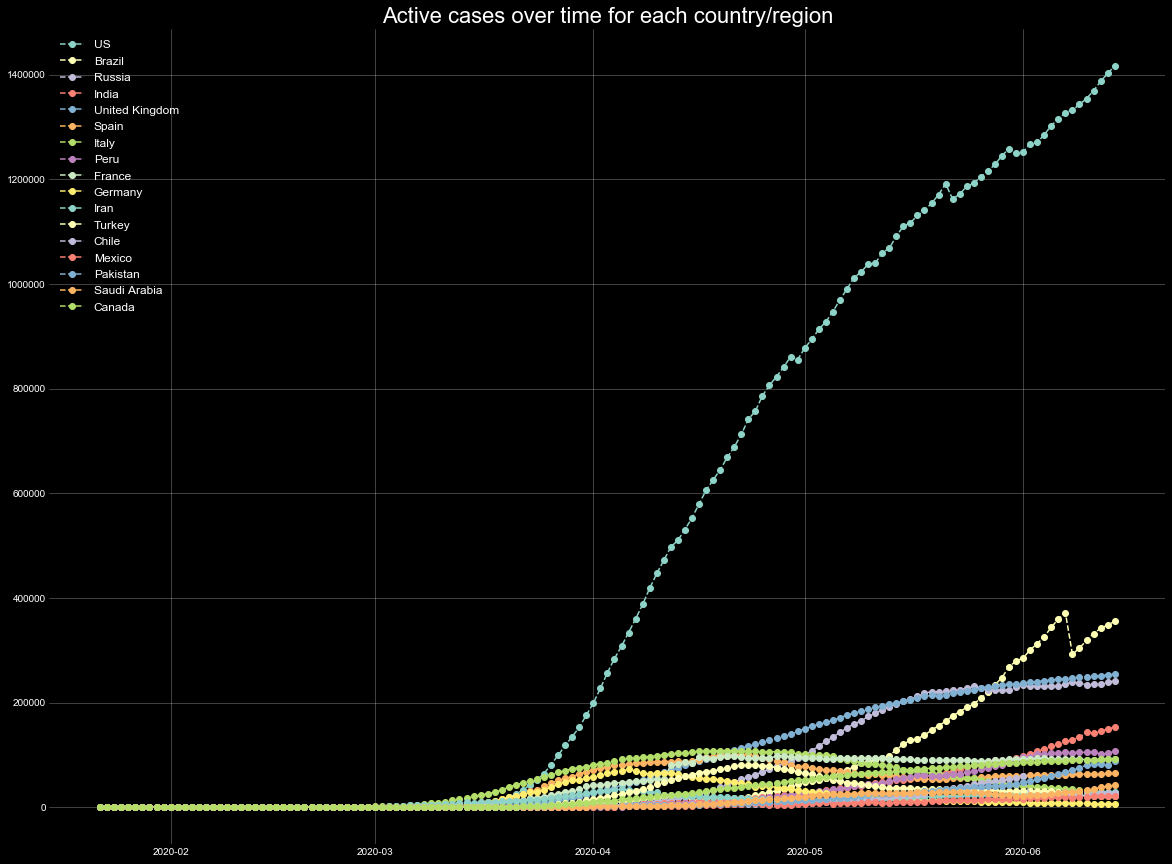

In [167]:
plot_overtime(df_affected,'Active','dark_background')

<Figure size 1440x1080 with 0 Axes>

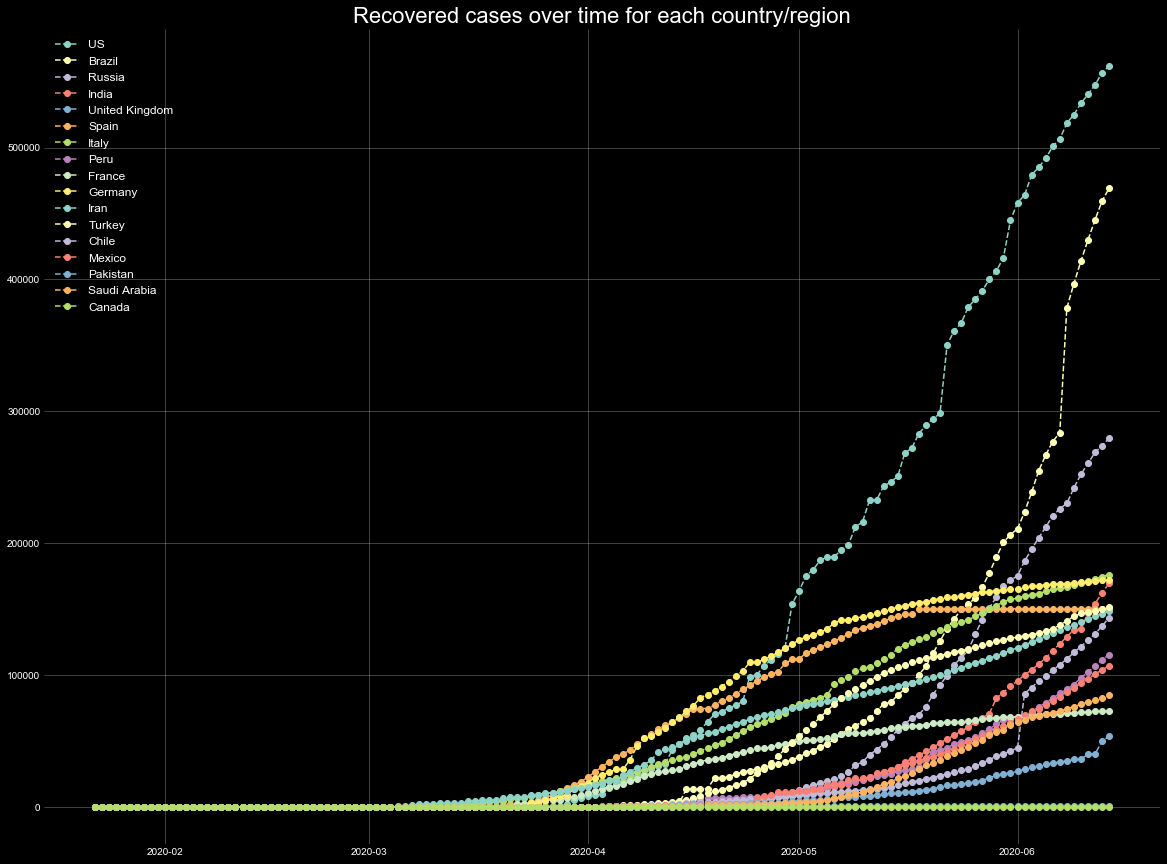

In [168]:
plot_overtime(df_affected,'Recovered','dark_background')

<Figure size 1440x1080 with 0 Axes>

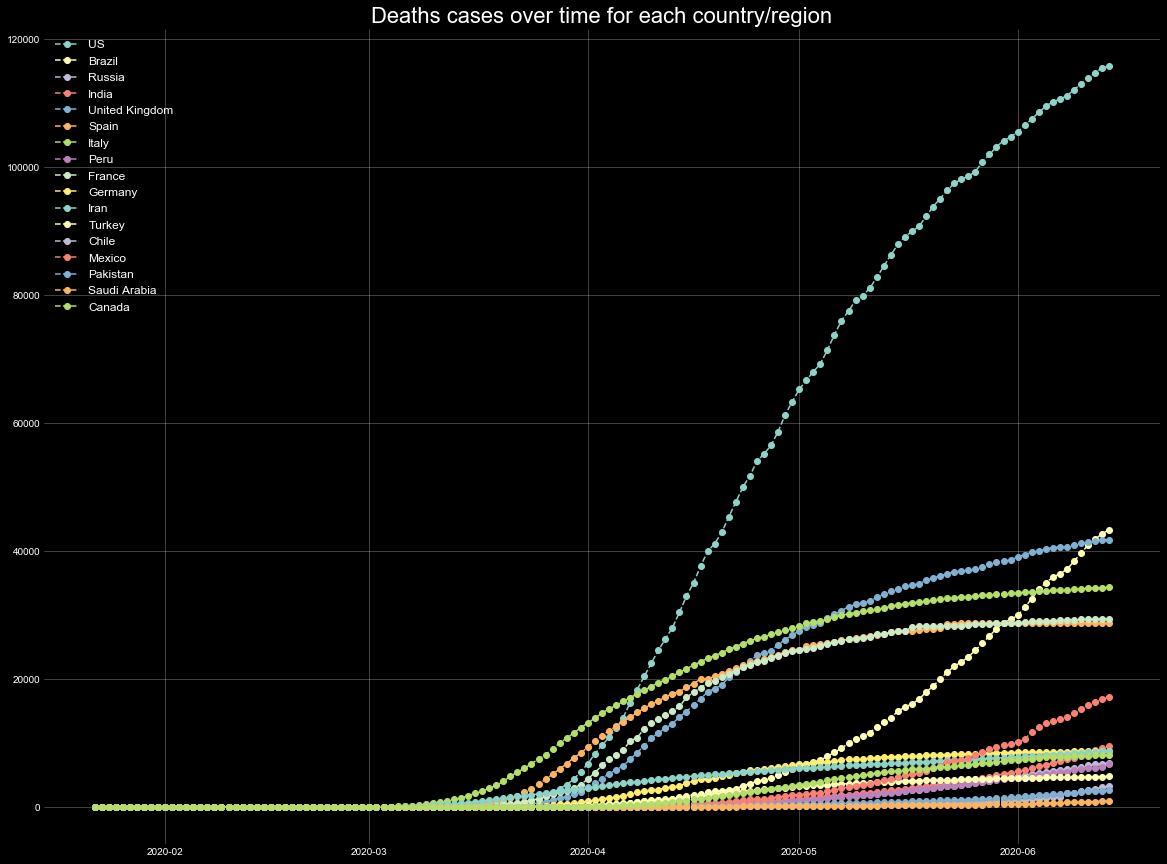

In [169]:
plot_overtime(df_affected,'Deaths','dark_background')


<Figure size 1440x1080 with 0 Axes>

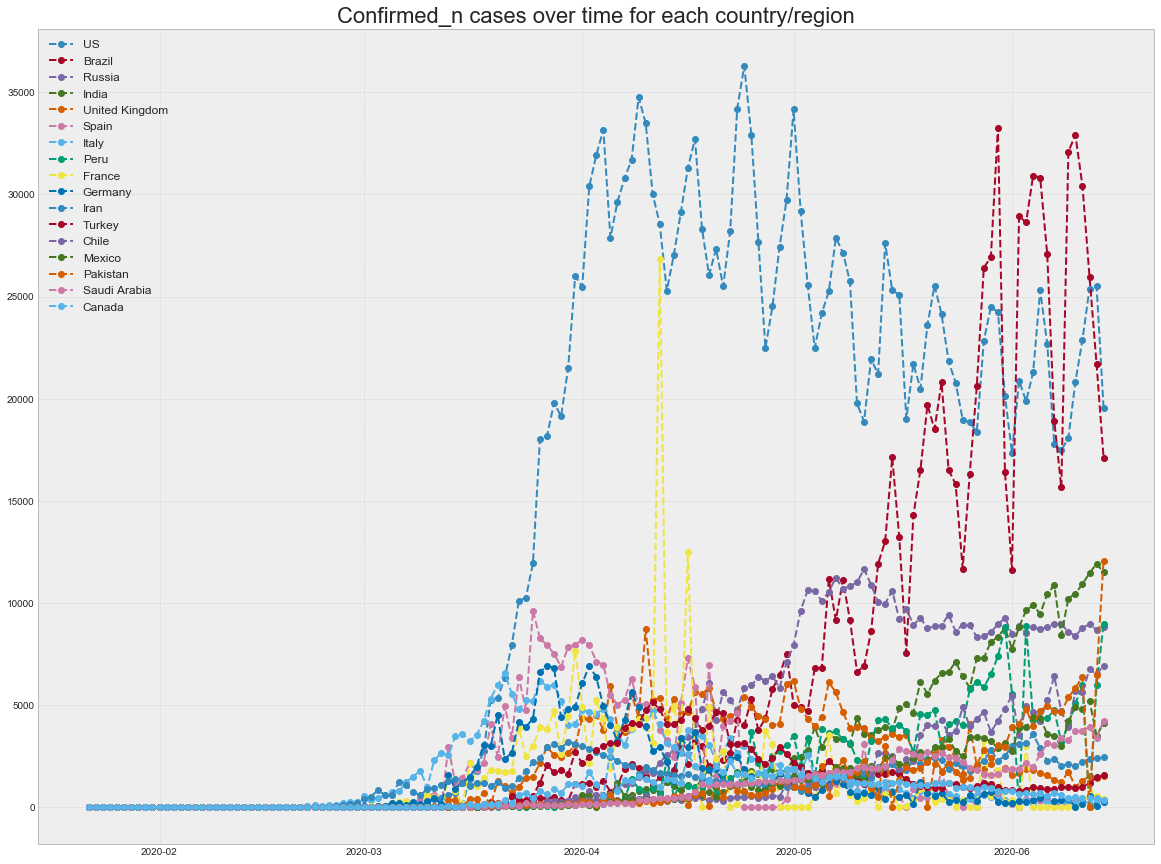

In [194]:
plot_overtime(df_affected,'Confirmed_n','bmh')


In [171]:
World_Data[World_Data['Confirmed_n']<0]

Empty DataFrame
Columns: [Country, Date, Confirmed, Deaths, Recovered, Confirmed_n, Deaths_n, Recovered_n, Active, Active_n]
Index: []

<Figure size 1440x1080 with 0 Axes>

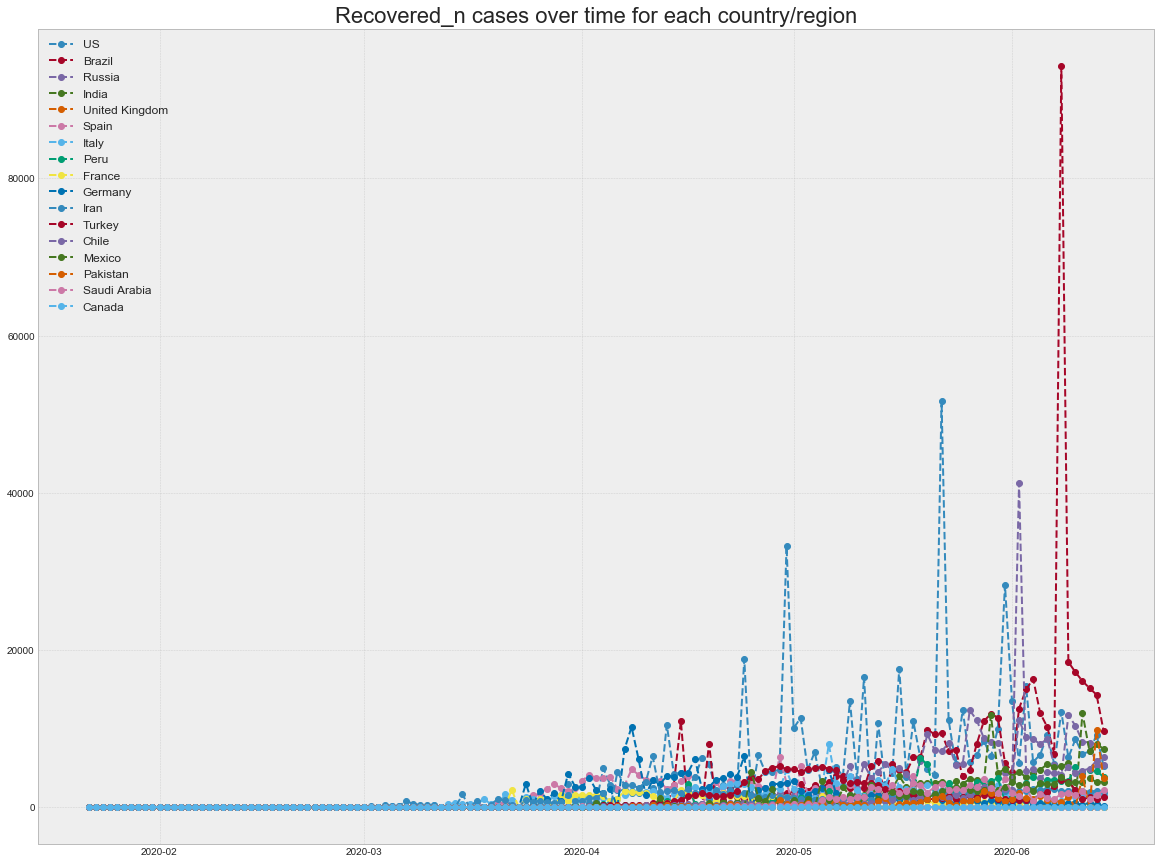

In [195]:
plot_overtime(df_affected,'Recovered_n','bmh')

<Figure size 1440x1080 with 0 Axes>

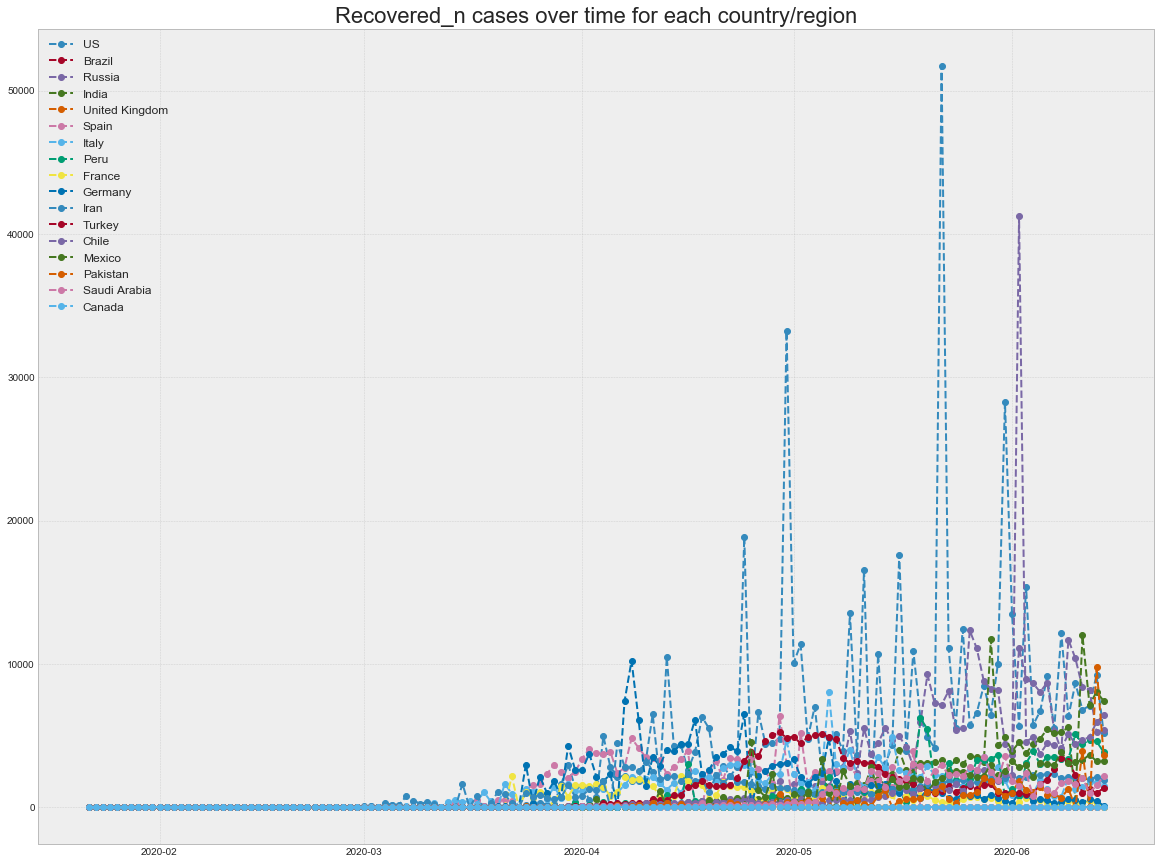

In [196]:
plot_overtime(df_affected[df_affected['Country']!='Brazil'],'Recovered_n','bmh')

<Figure size 1440x1080 with 0 Axes>

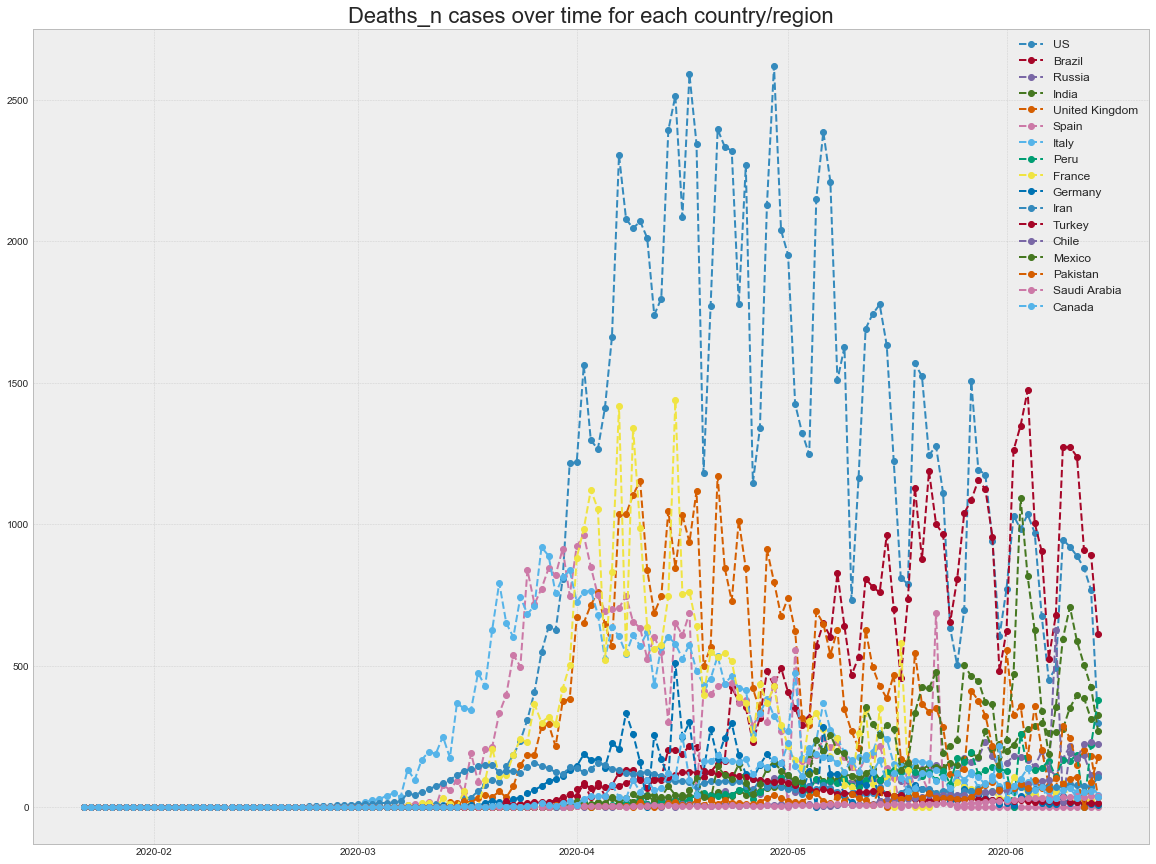

In [197]:
plot_overtime(df_affected,'Deaths_n','bmh')

In [497]:
#times = df_affected['Date'].unique()
#times=df_affected['Date'].strftime('%Y-%m').unique()
#xlim=[df_affected['Date'].min(),df_affected['Date'].max()]
#ylim=[df_affected['Confirmed'].min(),df_affected['Confirmed'].max()]
#g = sns.FacetGrid(df_affected, col="Country", col_wrap=3,height=3)
#g = g.map(sns.barplot, "Date", "Confirmed",order=times)


Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country')

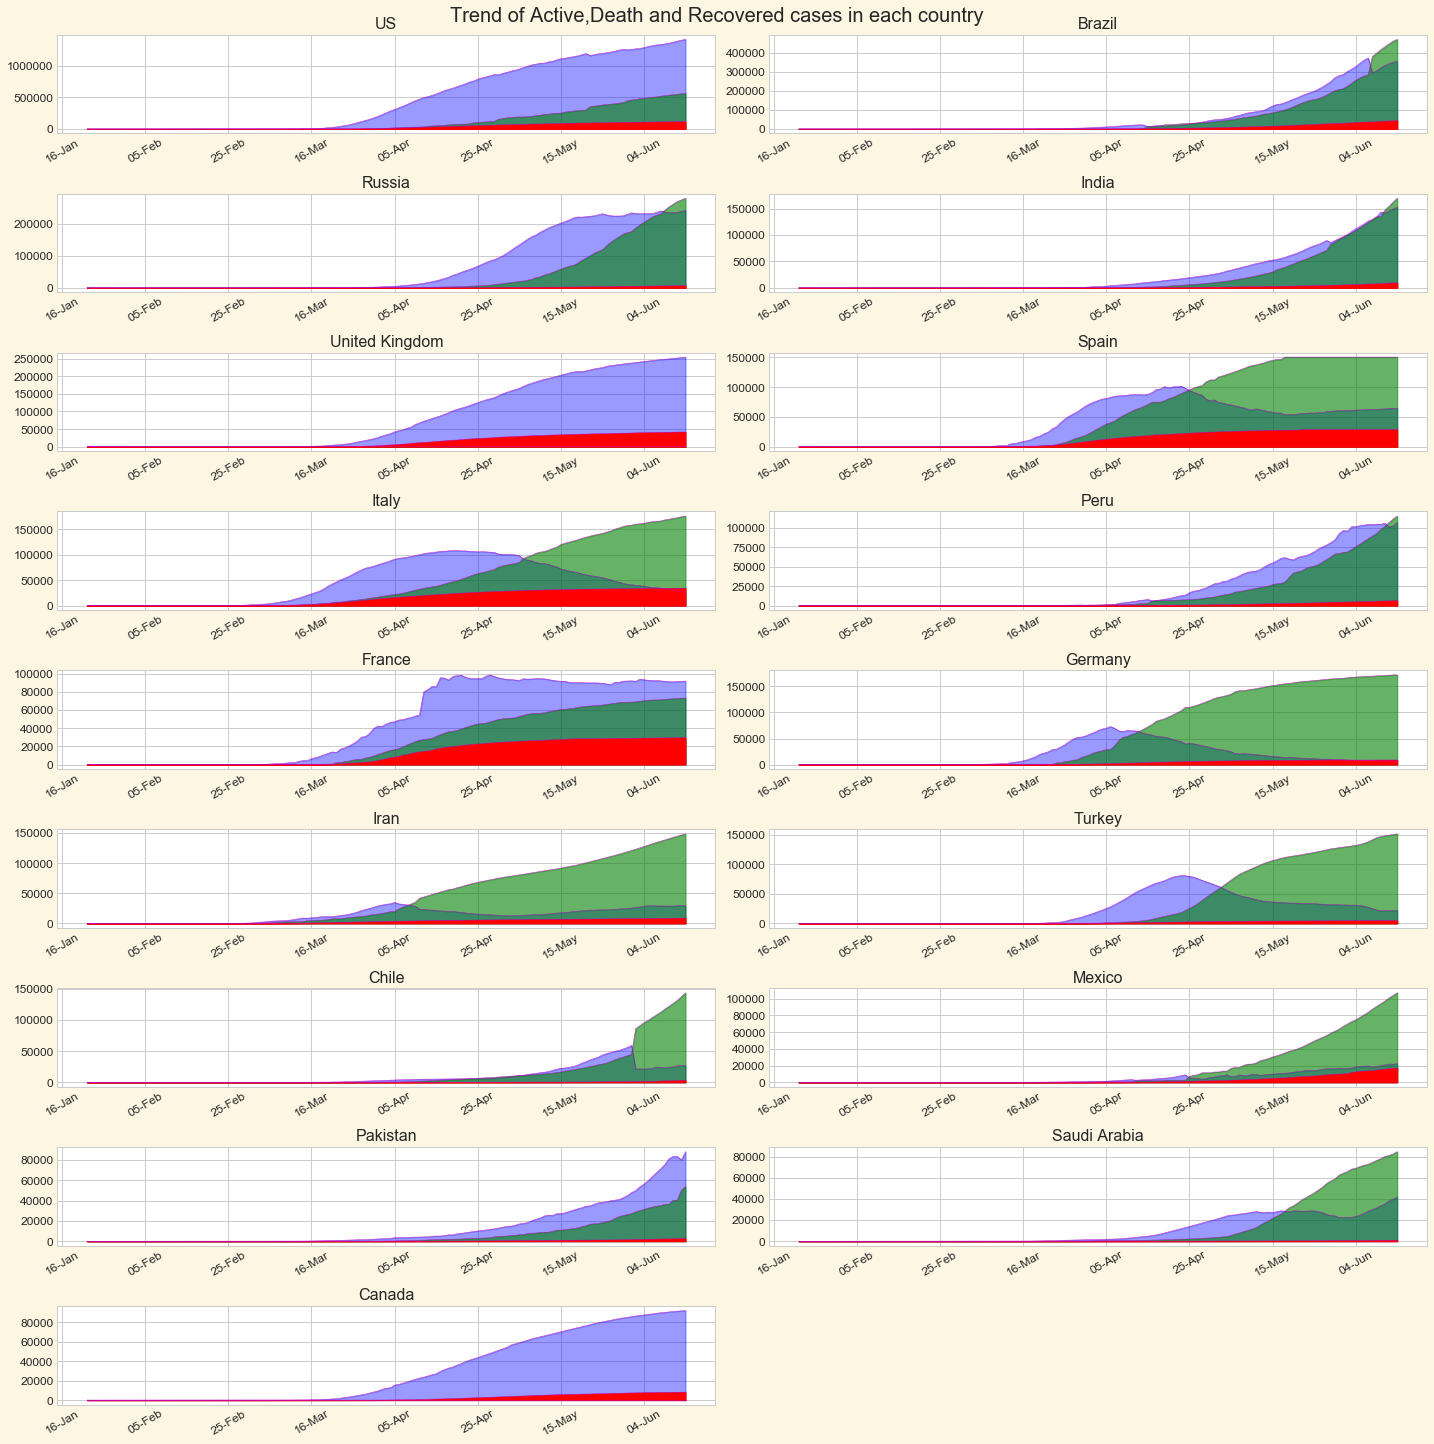

In [193]:
fig = plt.figure(figsize= (20,20))
plt.style.use('seaborn-whitegrid')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    axs.fill_between(df['Date'],df['Active'],color='blue',label = 'Active',alpha=0.4)
    axs.plot(df['Date'],df['Active'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Recovered'],color='green',label='Recovered',alpha=0.6)
    axs.plot(df['Date'],df['Recovered'],color='m',linewidth=0.5,alpha=0.9)
    axs.fill_between(df['Date'],df['Deaths'],color='red',label='Deaths')
    axs.plot(df['Date'],df['Deaths'],color='m',linewidth=0.5,alpha=0.9)
    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country',fontsize = 20,y=1.0)


With this plot, we can observe the trend of active cases, recoveries and deaths in each country which gives an idea on whether recoveries are at an increasing pace or active cases are at an increasing pace. In Italy, Spain and Germany, recovery rate is much higher which is observed in previous plots also[recovery rate plot] and active cases rate is decreasing gradually. In contrast, US Active cases are increasing at a much higher rate than its recovery rate.India, Pakistan and Peru showed almost similar trend in active cases and recovery rate. This might be because of poor lockdown regulations in US resulting in exponential growth of active cases. Lets have a look at stacked chart indicating the proportion of active , recovered and death cases in each country.

Text(0.5, 1.0, 'Trend of Active,Death and Recovered cases in each country[STACKED]')

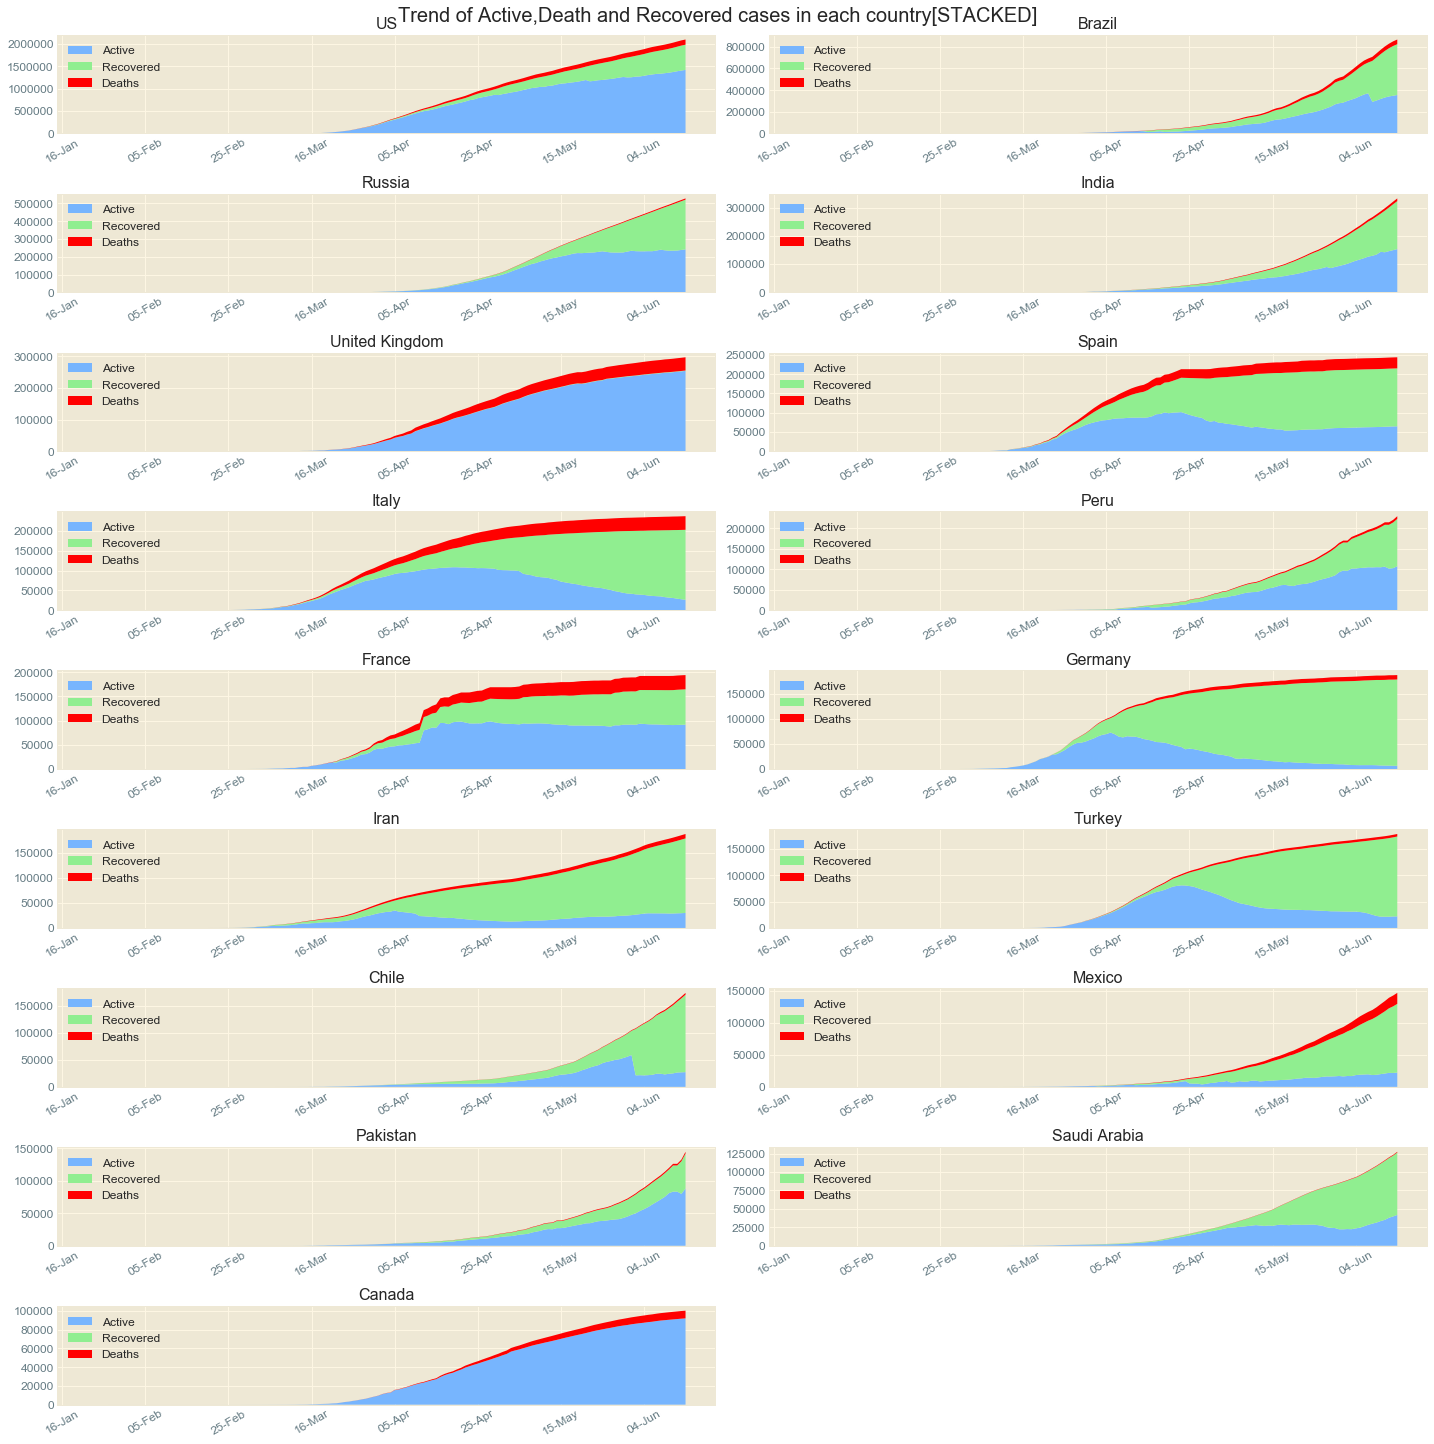

In [176]:
fig = plt.figure(figsize= (20,20))
plt.style.use('Solarize_Light2')

m= len(Affected)
max_rows=int((m+1)/2)
k=0
#fig,axs=plt.subplots(int(max_rows),2,figsize= (16,20),sharex=True,sharey=True)
for i,k in zip(Affected,range(1,m+1)):
    axs=fig.add_subplot(max_rows,2,k)
    df=df_affected[df_affected['Country']==i]
    color=['#77b5fe','#90EE90','r']
    axs.stackplot(df['Date'],df['Active'],df['Recovered'],df['Deaths'], labels=['Active','Recovered','Deaths'],colors=color)

    axs.xaxis.set_major_formatter(mdates.DateFormatter('%d-%b'))
    plt.xticks(rotation=30,fontsize=12)
    plt.yticks(fontsize=12)
    plt.title(i,fontsize=16)
    plt.locator_params(axis='y', nbins=6)
    axs.xaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.legend(loc='upper left',fontsize=12)
    k=k+1
plt.tight_layout(pad=1)
plt.suptitle('Trend of Active,Death and Recovered cases in each country[STACKED]',fontsize = 20,y=1.0)


As expected, Most of the countries have better recovered cases proportion and reduced active cases with time.But downward trend of active cases is not observed in some countries/regions like India,Pakistan and US.What could be possible reasons?- Number of tests done are not enough to find all existing cases? Strict lockdown is not implemented in those regions? How would be the case if there is no lockdown- exponential growth or different growth based on contacts ? Are we comparing regions just based on the confirmed cases, ignoring their population? 

In [177]:
url = 'https://www.worldometers.info/world-population/population-by-country'
html = requests.get(url).content
popu=pd.read_html(html)
population = popu[0]
population.rename(columns={'Country (or dependency)':'Country','Population (2020)':'Population'},inplace=True)
population.head()

#        Country  Population Yearly Change  Net Change  Density (P/Km²)  \
0  1          China  1439323776        0.39 %     5540090              153   
1  2          India  1380004385        0.99 %    13586631              464   
2  3  United States   331002651        0.59 %     1937734               36   
3  4      Indonesia   273523615        1.07 %     2898047              151   
4  5       Pakistan   220892340        2.00 %     4327022              287   

   Land Area (Km²)  Migrants (net) Fert. Rate Med. Age Urban Pop % World Share  
0          9388211       -348399.0        1.7       38        61 %     18.47 %  
1          2973190       -532687.0        2.2       28        35 %     17.70 %  
2          9147420        954806.0        1.8       38        83 %      4.25 %  
3          1811570        -98955.0        2.3       30        56 %      3.51 %  
4           770880       -233379.0        3.6       23        35 %      2.83 %

In [180]:
Data_r=Data_recent.copy()

Data_r= Data_r.join(population.set_index('Country')['Population'],on='Country')
Data_r[Data_r['Population'].isnull()]


Country       Date  Confirmed  Deaths  \
25229                                US 2020-06-14    2094058  115732   
13194                      Korea, South 2020-06-14      12121     277   
6524                            Czechia 2020-06-14      10024     330   
5944                      Cote d'Ivoire 2020-06-14       5084      45   
13339                            Kosovo 2020-06-14       1437      32   
6959                   Diamond Princess 2020-06-14        712      13   
21169             Sao Tome and Principe 2020-06-14        661      12   
26534                West Bank and Gaza 2020-06-14        492       3   
4059                              Burma 2020-06-14        261       6   
20879  Saint Vincent and the Grenadines 2020-06-14         27       0   
20589             Saint Kitts and Nevis 2020-06-14         15       0   
15079                        MS Zaandam 2020-06-14          9       2   

       Recovered  Confirmed_n  Deaths_n  Recovered_n   Active  Active_n  \
25229     561816        19532       296         5210  1416510     14026   
13194      10730           36         0           12     1114        24   
6524        7226           33         0            7     2468        26   
5944        2505          236         0          108     2534       128   
13339        928            0         0            0      477         0   
6959         651            0         0            0       48         0   
21169        177            2         0            1      472         1   
26534        415            3         0            0       74         3   
4059         167            0         0            0       88         0   
20879         25            0         0            0        2         0   
20589         15            0         0            0        0         0   
15079          0            0         0            0        7         0   

       Deathrate  Recoveryrate  Population  
25229       5.53         26.83         NaN  
13194       2.29         88.52         NaN  
6524        3.29         72.09         NaN  
5944        0.89         49.27         NaN  
13339       2.23         64.58         NaN  
6959        1.83         91.43         NaN  
21169       1.82         26.78         NaN  
26534       0.61         84.35         NaN  
4059        2.30         63.98         NaN  
20879       0.00         92.59         NaN  
20589       0.00        100.00         NaN  
15079      22.22          0.00         NaN

In [181]:
Data_r.loc[Data_r['Country']=='US','Population']=population.loc[population['Country']=='United States','Population'].values
Data_r.loc[Data_r['Country']=='Korea, South','Population']=population.loc[population['Country']=='South Korea','Population'].values
Data_r.loc[Data_r['Country']=='Czechia','Population']=population.loc[population['Country']=='Czech Republic (Czechia)','Population'].values
Data_r.loc[Data_r['Country']=='Cote d\'Ivoire','Population']=population.loc[population['Country']=='Côte d\'Ivoire','Population'].values

Data_r.loc[Data_r['Country']=='Sao Tome and Principe','Population']=population.loc[population['Country']=='Sao Tome & Principe','Population'].values

Data_r.loc[Data_r['Country']=='Saint Kitts and Nevis','Population']=population.loc[population['Country']=='Saint Kitts & Nevis','Population'].values
Data_r.loc[Data_r['Country']=='Saint Vincent and the Grenadines','Population']=population.loc[population['Country']=='St. Vincent & Grenadines','Population'].values
Data_r.loc[Data_r['Country']=='Kosovo','Population']=1810366
Data_r.loc[Data_r['Country']=='Burma','Population']= 54409800
Data_r.loc[Data_r['Country']=='West Bank and Gaza','Population']=4570000

Chloroeth map- animation; population extraction and confirmed percent of population ; new cases each day or daily infection rate, if no lockdown how would be confirmed cases with lockdown how it is ?- this will give the impact of strict lockdowns- may be exponential rate ; state wise cholopleth ; population; increase rate in confirmed cases from prev day; first case in each location gannt chart

In [182]:
Data_r[Data_r['Population'].isnull()]


Country       Date  Confirmed  Deaths  Recovered  Confirmed_n  \
6959   Diamond Princess 2020-06-14        712      13        651            0   
15079        MS Zaandam 2020-06-14          9       2          0            0   

       Deaths_n  Recovered_n  Active  Active_n  Deathrate  Recoveryrate  \
6959          0            0      48         0       1.83         91.43   
15079         0            0       7         0      22.22          0.00   

       Population  
6959          NaN  
15079         NaN

In [187]:
Data_r=Data_r.dropna(subset=['Population'])
Data_r[Data_r['Population'].isnull()]


Empty DataFrame
Columns: [Country, Date, Confirmed, Deaths, Recovered, Confirmed_n, Deaths_n, Recovered_n, Active, Active_n, Deathrate, Recoveryrate, Population, Confirmed_perM, Recovered_perM, Deaths_perM, Active_perM]
Index: []

Cases as a percentage of population or cases per million population--normalization 

In [188]:
Data_r['Population']=Data_r['Population'].astype('int')
Data_r['Confirmed_perM']= round(Data_r['Confirmed']/Data_r['Population']*1000000,0).astype('int')
Data_r['Recovered_perM']= round(Data_r['Recovered']/Data_r['Population']*1000000,0).astype('int')
Data_r['Deaths_perM']= round(Data_r['Deaths']/Data_r['Population']*1000000,0).astype('int')
Data_r['Active_perM']= round(Data_r['Active']/Data_r['Population']*1000000,0).astype('int')

In [189]:
Most_affected_perM=Data_r.sort_values(by=['Confirmed_perM'],ascending=False).head(20)


From this data, its clear that the countries with high number of confirmed cases are not the same as countries with high number of confirmed cases per million. As per the number of confirmed cases, India stands in top 10 but we can say that the spread of COVID is much less than other countries based on population data. 


In [191]:
Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False).style.background_gradient(cmap='Blues',subset=["Confirmed"])\
                        .background_gradient(cmap='Reds',subset=["Deaths"])\
                        .background_gradient(cmap='Greens',subset=["Recovered"])\
                        .background_gradient(cmap='Purples',subset=["Active"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_n"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_n"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_n"])\
                        .background_gradient(cmap='YlOrBr',subset=["Active_n"])\
                        .background_gradient(cmap='spring',subset=["Deathrate"])\
                        .background_gradient(cmap='summer',subset=["Recoveryrate"])\
                        .background_gradient(cmap='Reds',subset=["Deaths_perM"])\
                        .background_gradient(cmap='Greens',subset=["Recovered_perM"])\
                        .background_gradient(cmap='Purples',subset=["Active_perM"])\
                        .background_gradient(cmap='Blues',subset=["Confirmed_perM"])\

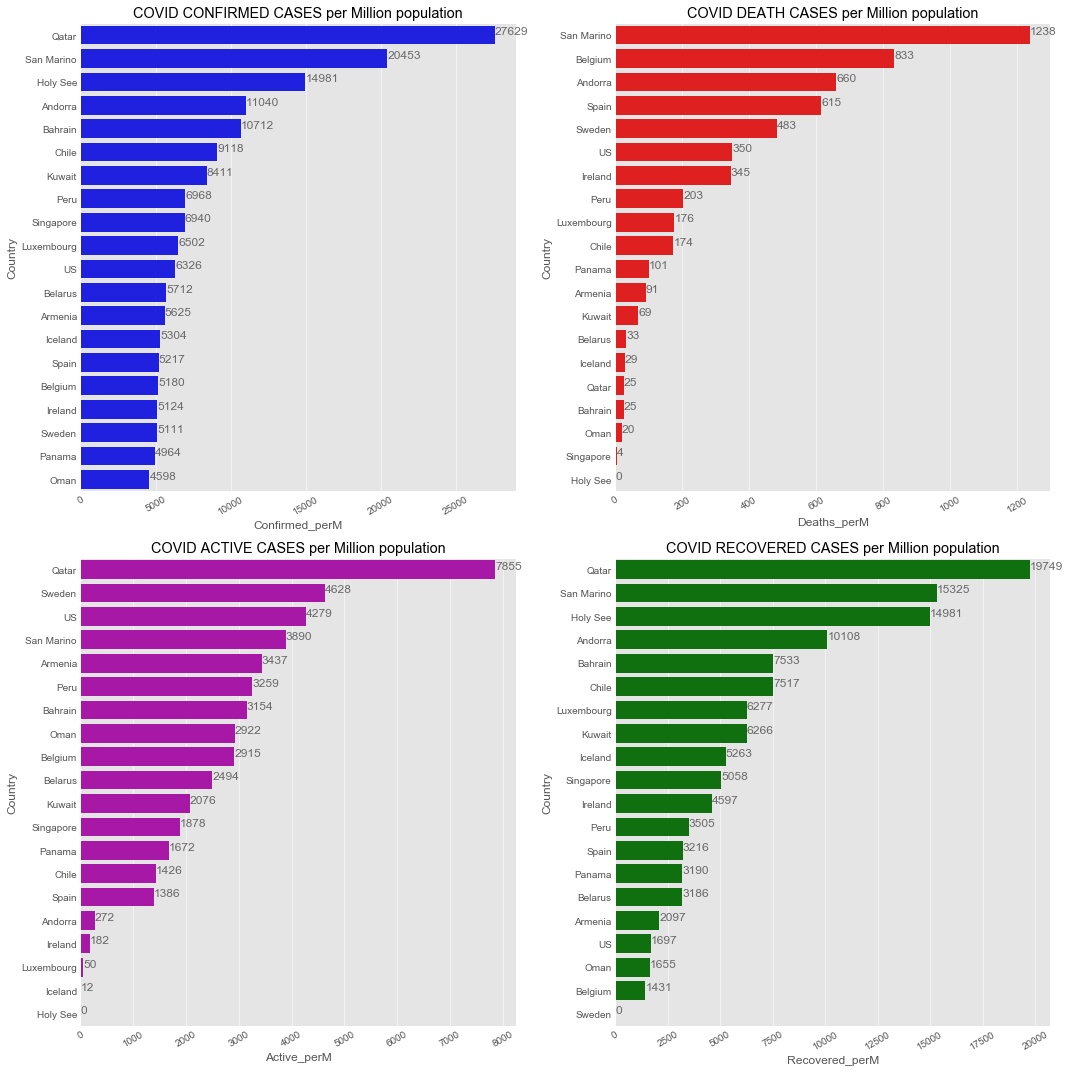

In [263]:
f, axes = plt.subplots(2, 2, figsize=(15, 15))

ax1=sns.barplot(x='Confirmed_perM',y='Country',data= Most_affected_perM.sort_values(by=['Confirmed_perM'],ascending=False),color='blue',ax=axes[0, 0])
plt.setp(axes[0,0].get_xticklabels(),visible=True, rotation=30)
ax1.set_title("COVID CONFIRMED CASES per Million population")
total_c=[]

for i in ax1.patches:
    ax1.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')

ax2=sns.barplot(x='Deaths_perM',y='Country',data= Most_affected_perM.sort_values(by=['Deaths_perM'],ascending=False),color='red',ax=axes[0, 1])
plt.setp(axes[0,1].get_xticklabels(), rotation=30)
ax2.set_title("COVID DEATH CASES per Million population")
total_c=[]

for i in ax2.patches:
    ax2.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax3=sns.barplot(x='Active_perM',y='Country',data= Most_affected_perM.sort_values(by=['Active_perM'],ascending=False),color='m',ax=axes[1, 0])
plt.setp(axes[1,0].get_xticklabels(), rotation=30)
ax3.set_title("COVID ACTIVE CASES per Million population")
total_c=[]
#for i in ax3.patches:
#    total_c.append(i.get_width())
for i in ax3.patches:
    ax3.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4=sns.barplot(x='Recovered_perM',y='Country',data= Most_affected_perM.sort_values(by=['Recovered_perM'],ascending=False),color='green',ax=axes[1, 1])
plt.setp(axes[1,1].get_xticklabels(), rotation=30)

for i in ax4.patches:
    ax4.text(i.get_width()+.3, i.get_y()+.38,int(i.get_width()), fontsize=12,color='dimgrey')
ax4.set_title("COVID RECOVERED CASES per Million population")
plt.tight_layout()


In [ ]:
!wget --quiet https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DV0101EN/labs/Data_Files/world_countries.json -O world_countries.json
    
print('GeoJSON file downloaded!')
world_geo = r'world_countries.json' # geojson file

# create a plain world map

w= folium.Map(location=[0,0],zoom_start=2,tiles='Mapbox Bright')
folium.Choropleth(
    geo_data=world_geo,
    data=Data_recent,
    columns=['Country', 'Confirmed'],
    key_on='feature.properties.name',
    fill_color='YlOrRd', 
    fill_opacity=0.8, 
    line_opacity=0.2,
    legend_name='Confirmed'
).add_to(w)
w